# NICO2AI Lecture12 Reinforcement Learning II Practice

## ChainerRL
- website https://github.com/chainer/chainerrl

ChainerRL is reinforcement learning library provided by PFN. Many kinds of algorithms are available and easily experimented on ALE or OpenAI Gym. Here is implemented algorithms.

- DQN
- Double DQN
- Dueling DQN
- DDPG
- A3C
- N-step Q Learning
- PCL

## CartPole with Deep Neural Network
To learn how to use ChainerRL, let's implement DQN with fully connected layers powered by ChainerRL. Unlike CartPole with discretized state space previsouly you created, DQN is able to deal with continous state space because deep neural network approximate action values from direct inputs, what we call end-to-end. Fill blanks to complete DQN agent.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
from collections import deque
from IPython.display import display, clear_output

env = gym.make('CartPole-v0')

# deep neural network with 3 fully connected layers
class QFunction(chainer.Chain):
    def __init__(self, num_state, num_actions, n_hidden_channels=50):
        super().__init__(
            l0=L.Linear(num_state, n_hidden_channels),
            l1=L.Linear(n_hidden_channels, n_hidden_channels),
            l2=L.Linear(n_hidden_channels, num_actions))

    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        out = self.l2(h)
        # wrapper for discrete action space
        return chainerrl.action_value.DiscreteActionValue(out)

# ChainerRL also has replay memory used in DQN, but create original one here.
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, next_action, is_state_terminal):
        experience = dict(state=state, action=action, reward=reward,
                next_state=next_state, next_action=next_action,
                is_state_terminal=is_state_terminal)
        self.memory.append(experience)
    
    def sample(self, n):
        return random.sample(self.memory, n)
    
    def __len__(self):
        return len(self.memory)
    
    def stop_current_episode(self):
        pass
    
q_func = QFunction(4, 2)

optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

# ChainerRL provides some exploration strategies
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.1, random_action_func=lambda: np.random.choice(2))

# Buffer size is 10^5 which is smaller than 10^6 used in the paper
# because replay buffer actually occupies large memory space
# replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 5)
replay_buffer = ReplayBuffer(capacity=10 ** 5)

discount = 0.9

# DQN agent offered by ChainerRL with modular structure
agent = chainerrl.agents.DQN(
    q_func, optimizer, replay_buffer, discount, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=lambda x: np.array(x, dtype=np.float32))

[2017-08-26 23:04:04,161] Making new env: CartPole-v0


Now you have DQN agent capable of predicting action values by end-to-end training.

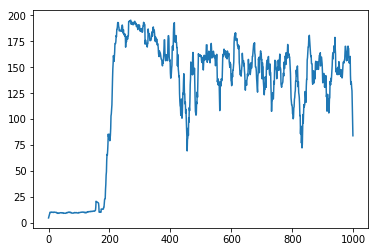

In [2]:
rewards = []
# this may take a few minutes
for i in range(1000):
    state = env.reset()
    sum_of_rewards = 0
    reward = 0
    
    while True:
        action = agent.act_and_train(state, reward)
        state, reward, done, _ = env.step(action)
        sum_of_rewards += reward
        if done:
            agent.stop_episode_and_train(state, reward, done)
            break
    rewards.append(sum_of_rewards)

plt.plot(np.arange(1000), np.convolve(rewards, np.ones(10) / 10, mode='same'))

Let's check agent behavior.


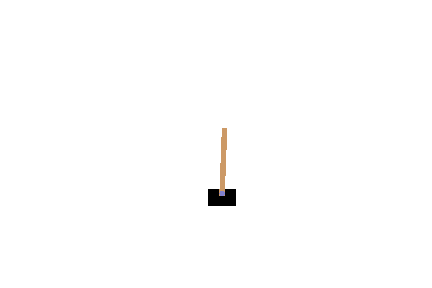
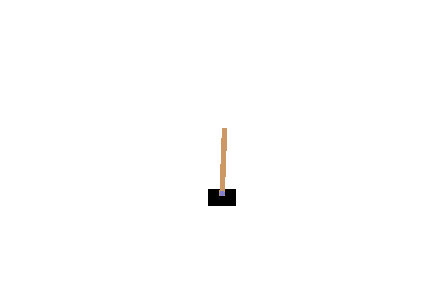
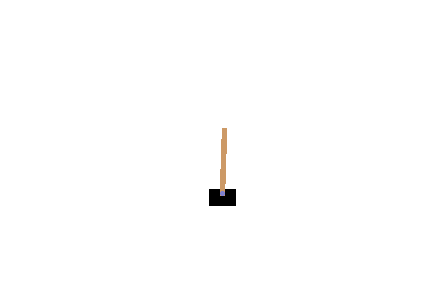
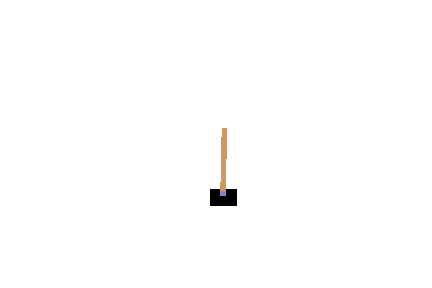
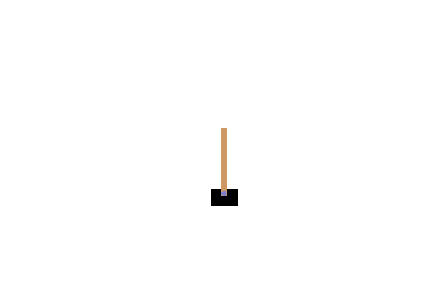
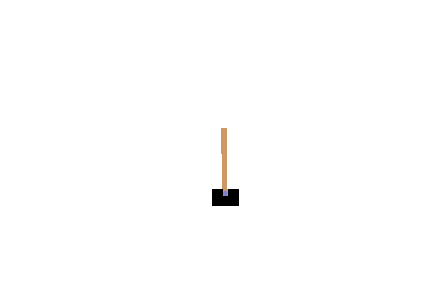
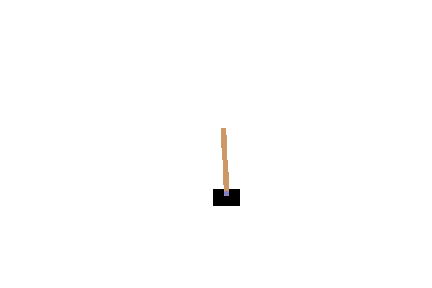
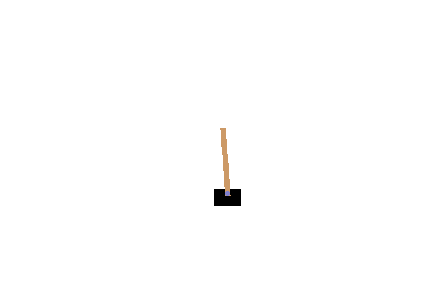
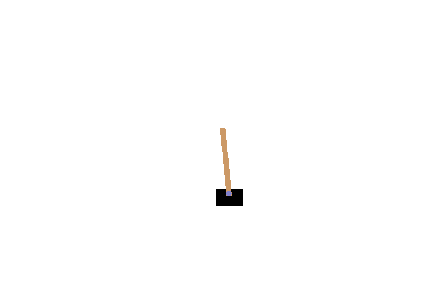
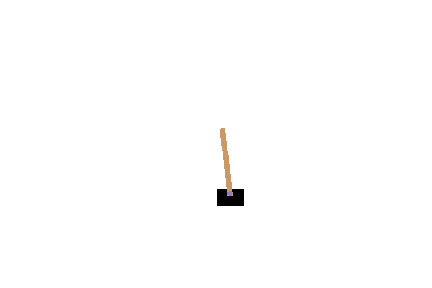
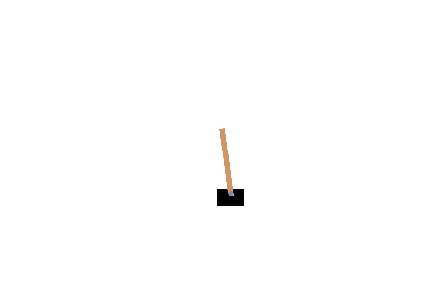
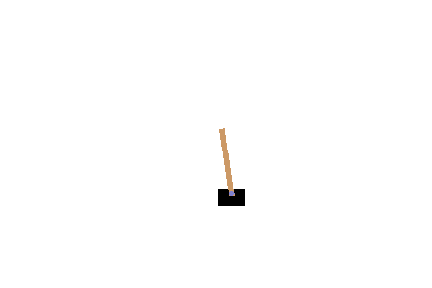
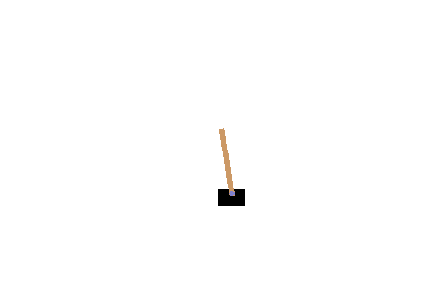
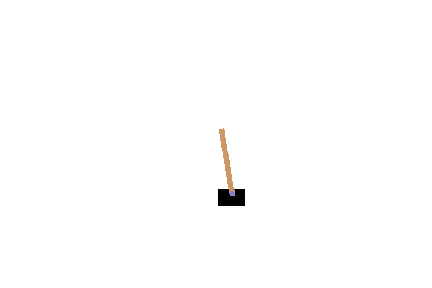
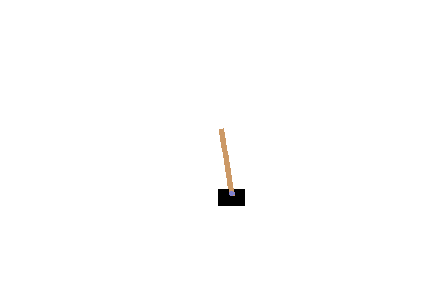
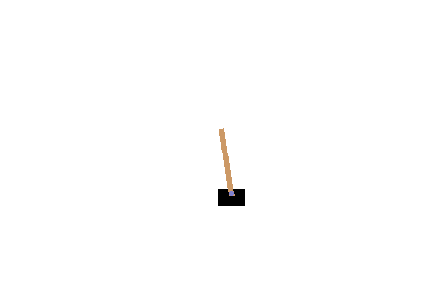
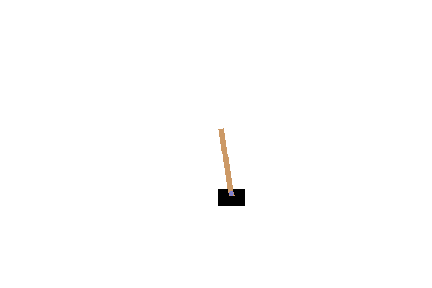
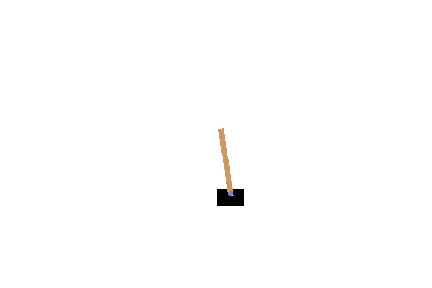
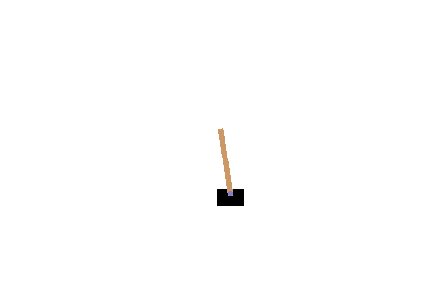
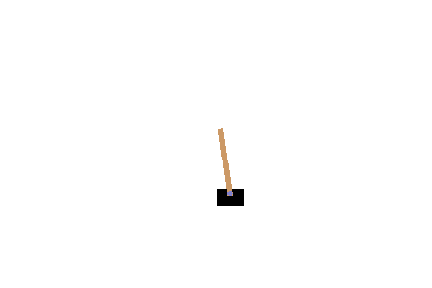
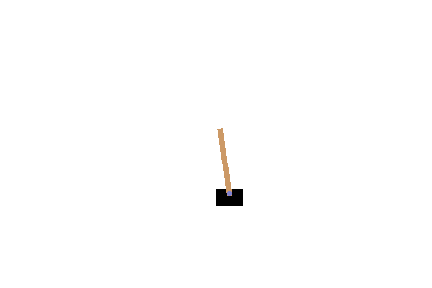
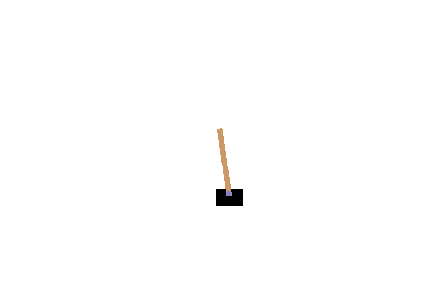
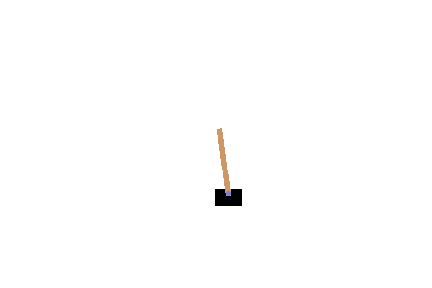
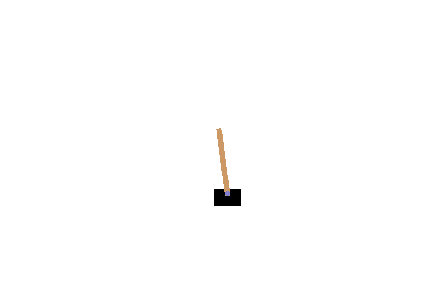
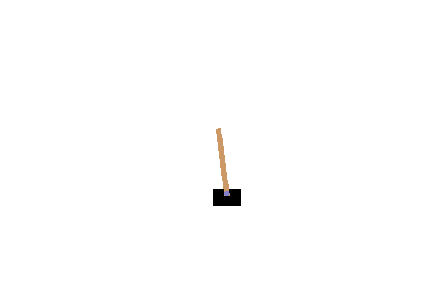
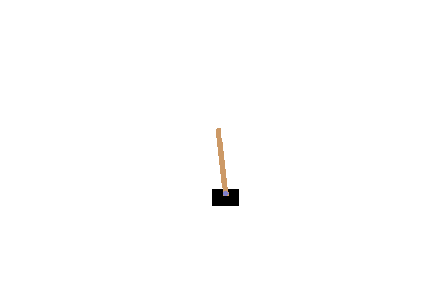
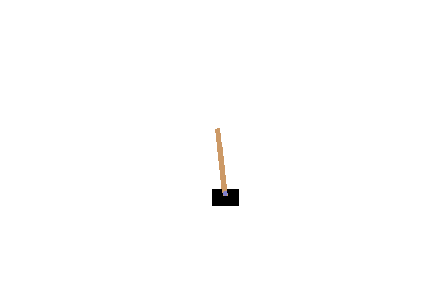
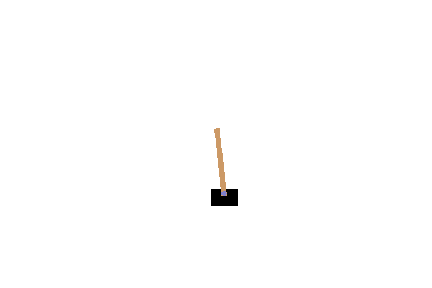
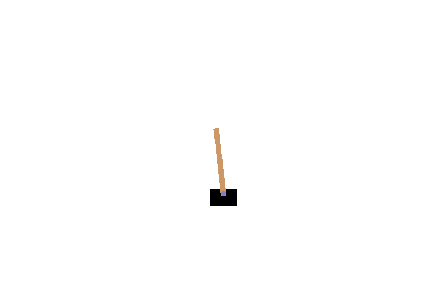
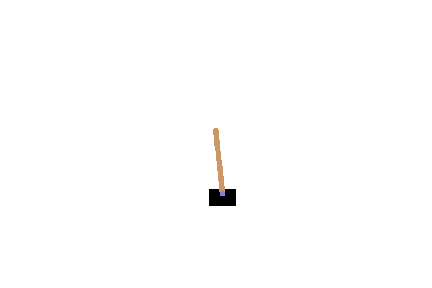
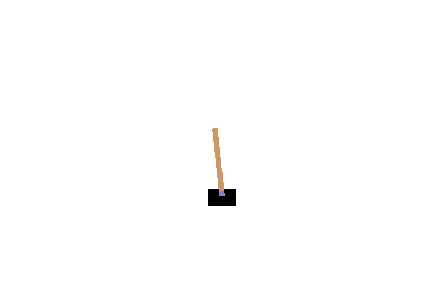
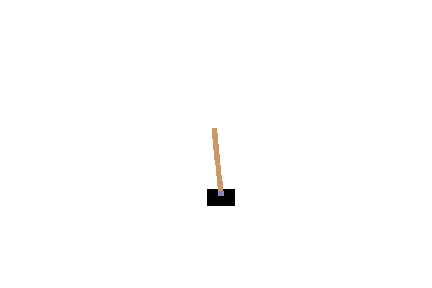
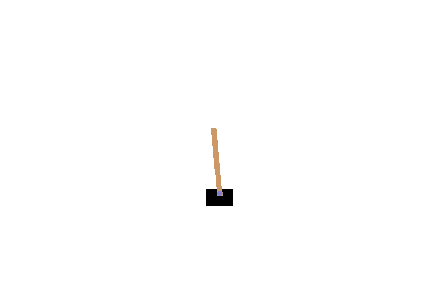
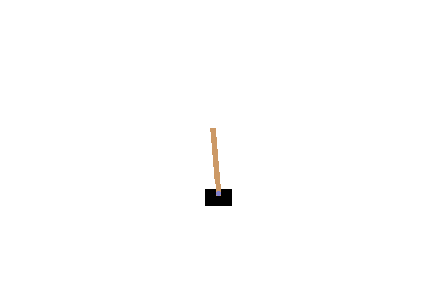
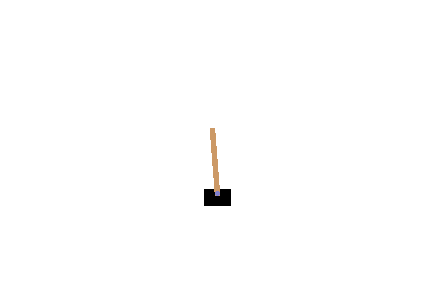
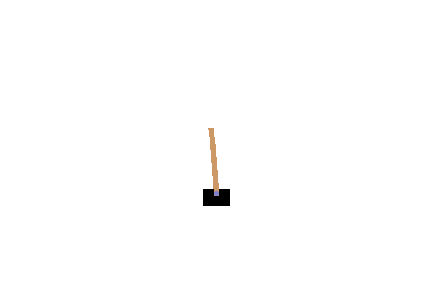
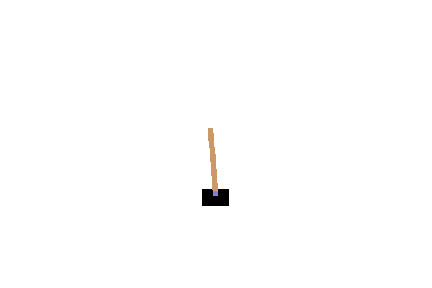
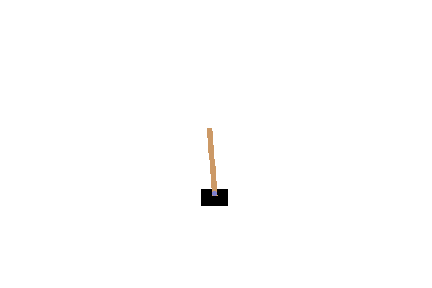
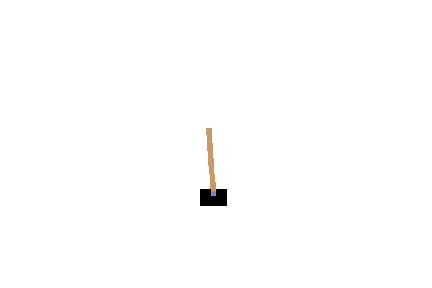
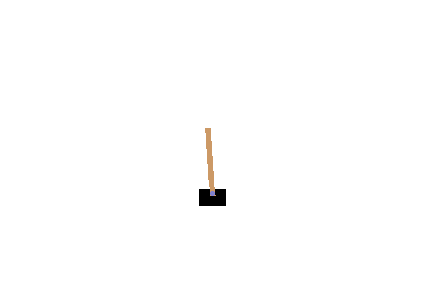
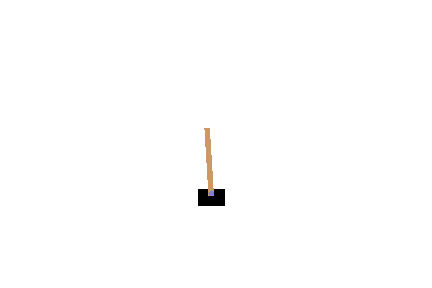
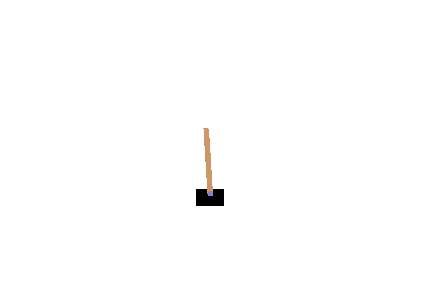
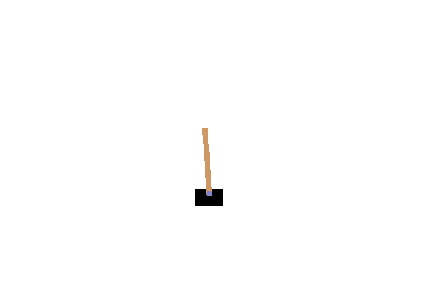
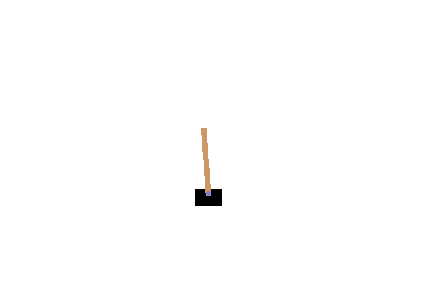
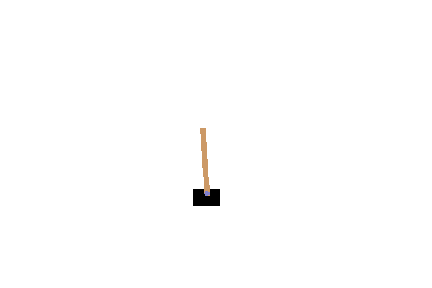
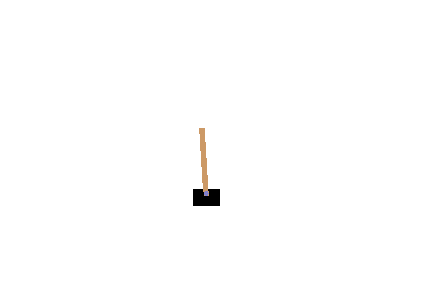
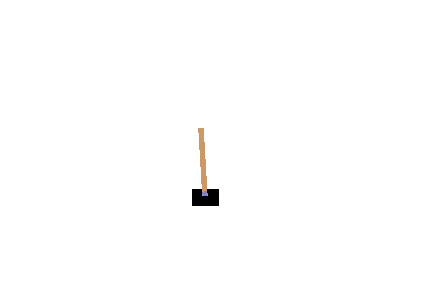
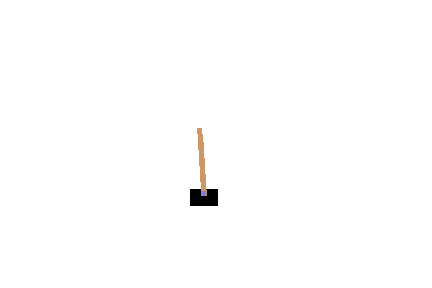
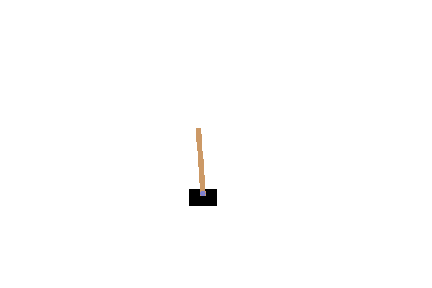
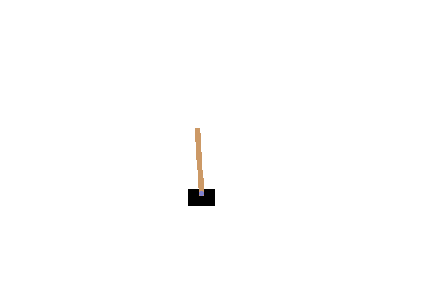
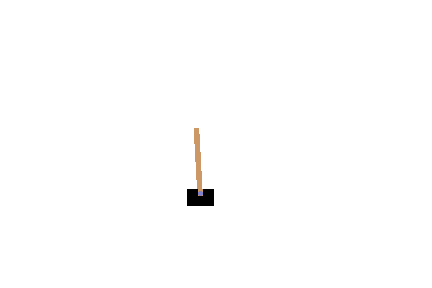
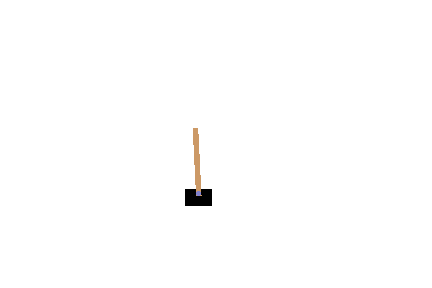
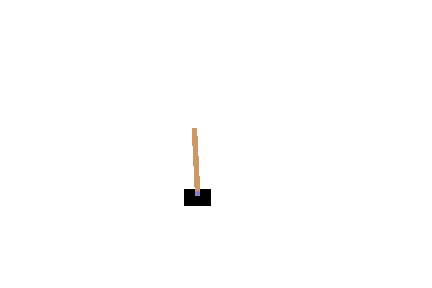
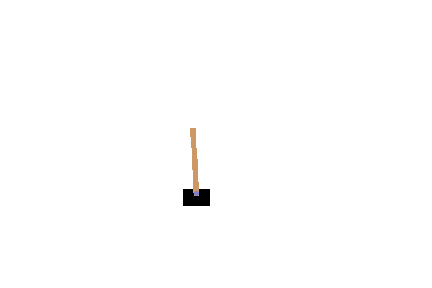
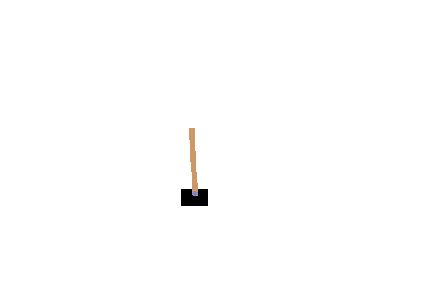
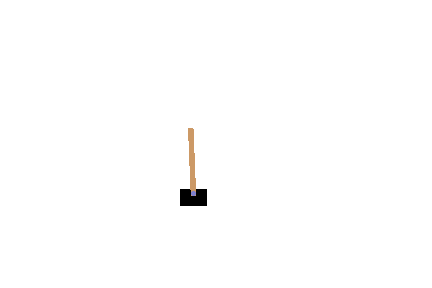
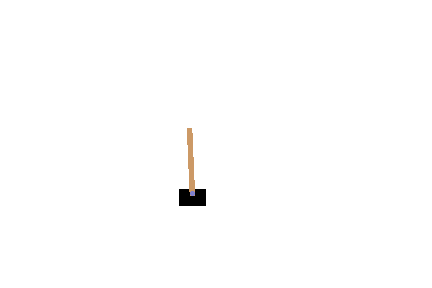
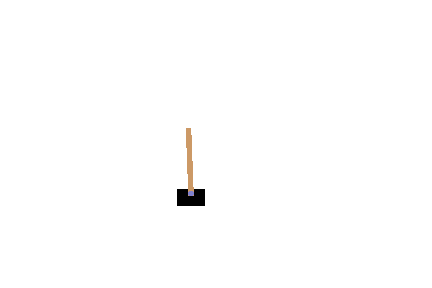
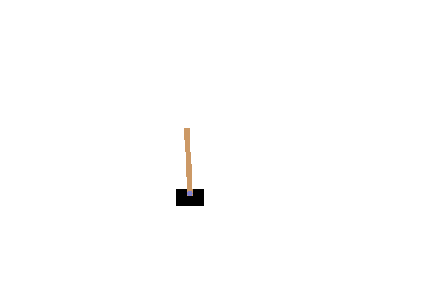
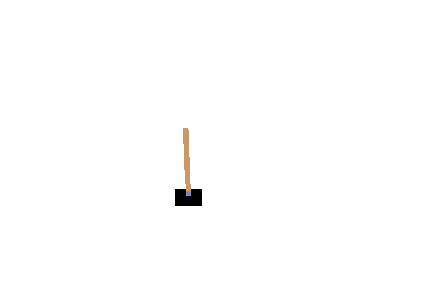
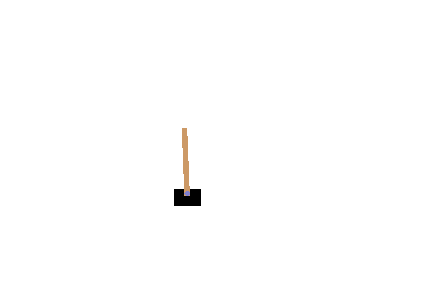
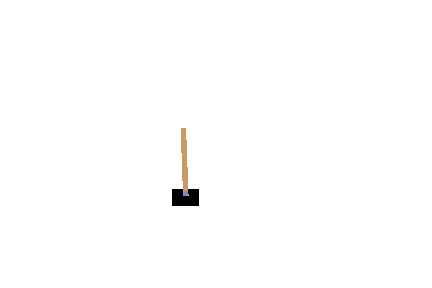
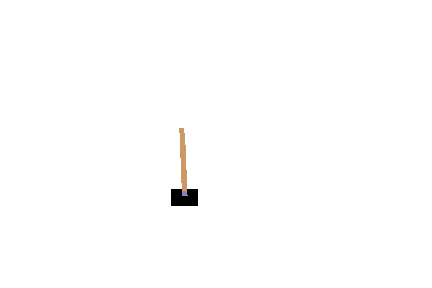
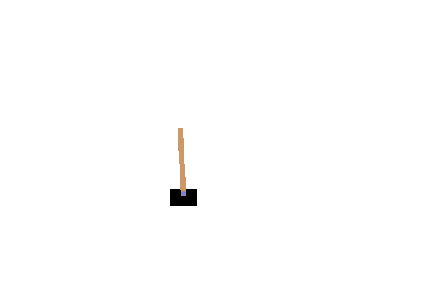
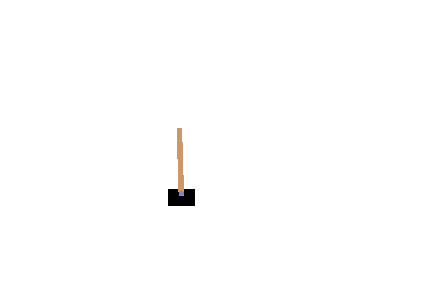
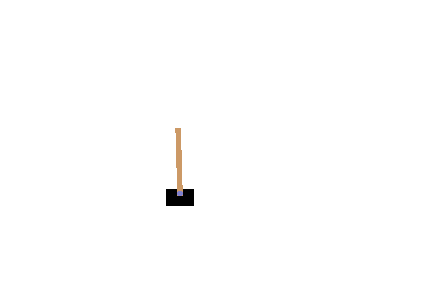
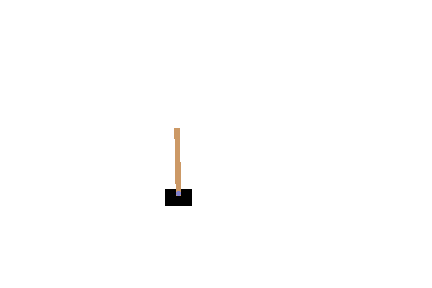
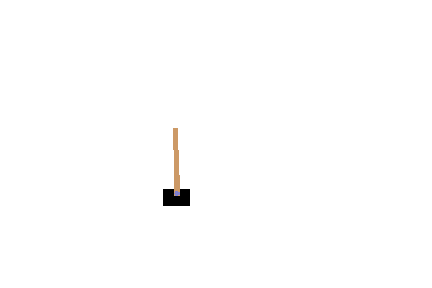
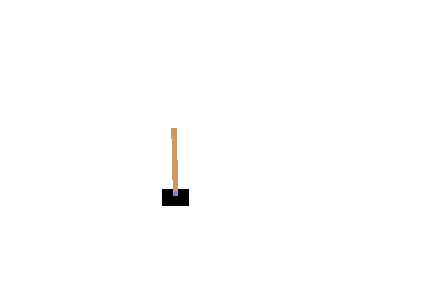
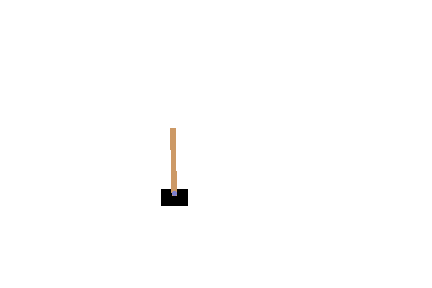
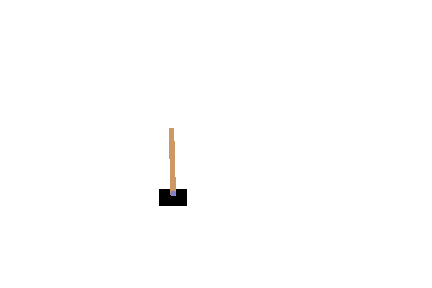
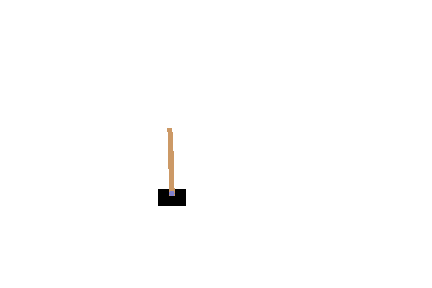
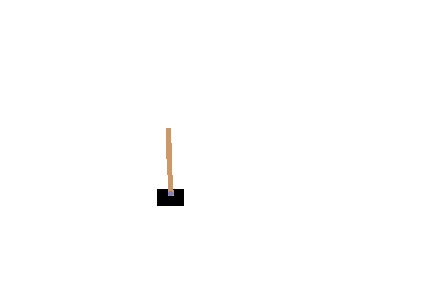
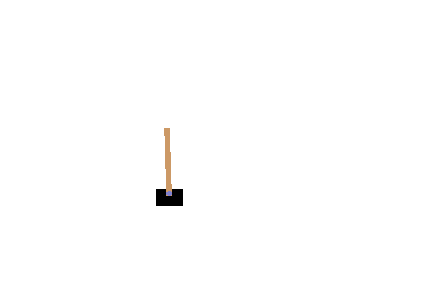
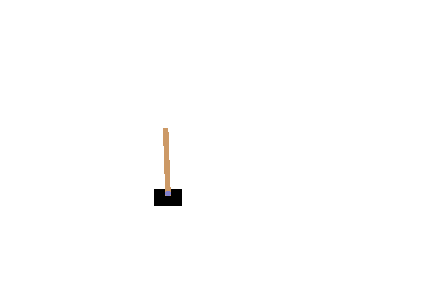
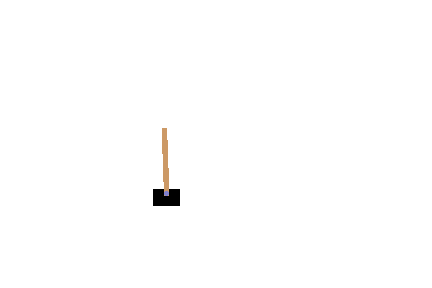
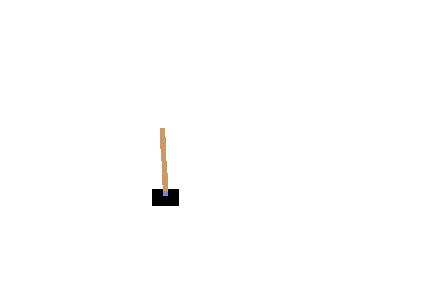
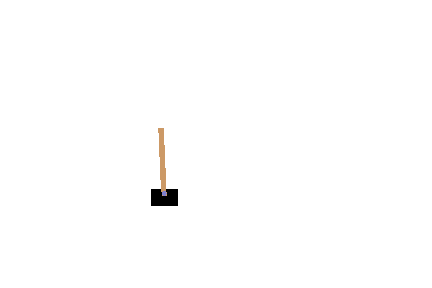
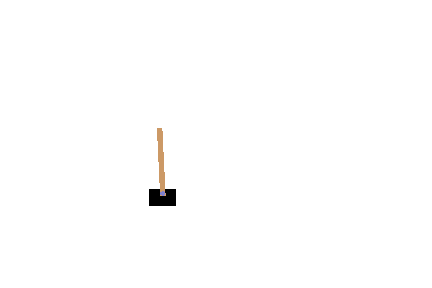
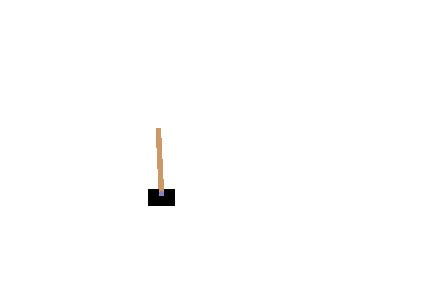
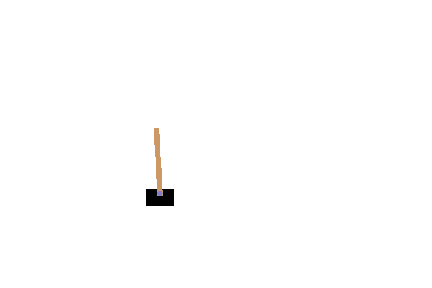
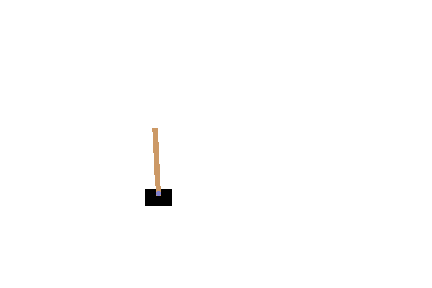
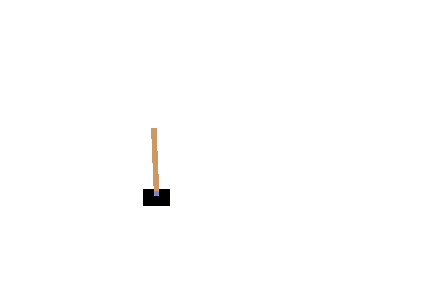
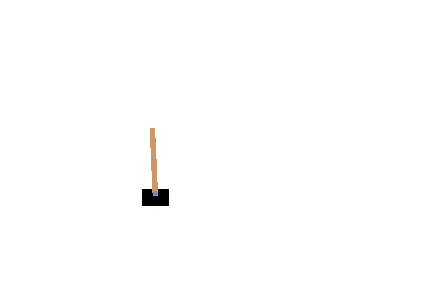
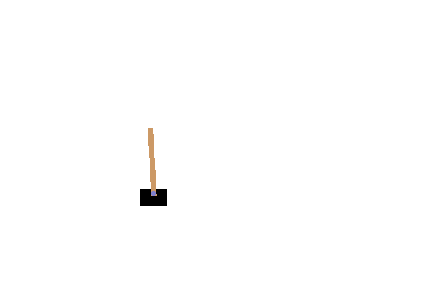
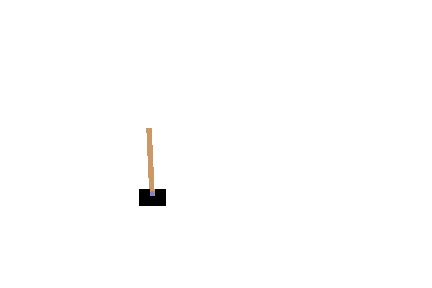
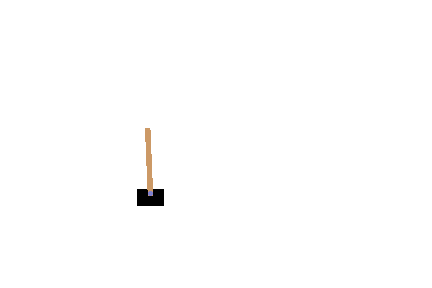
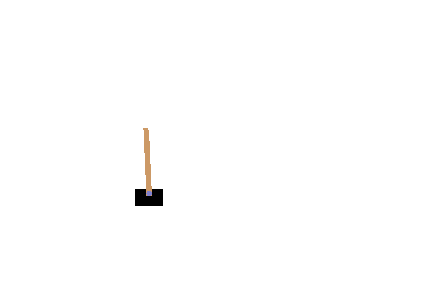
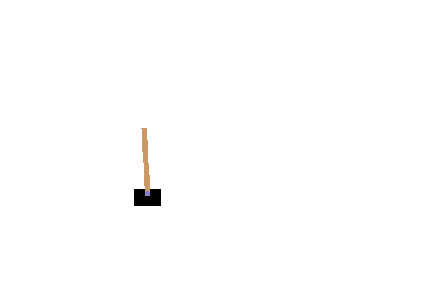
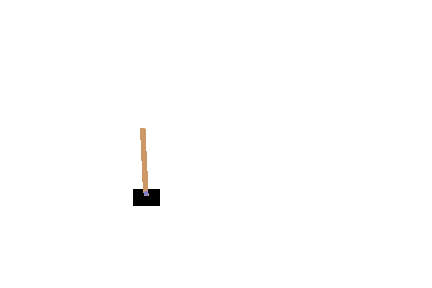
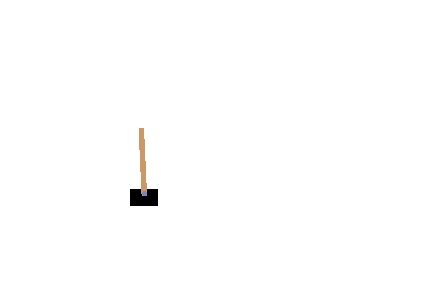
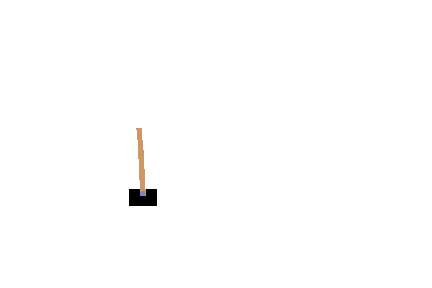
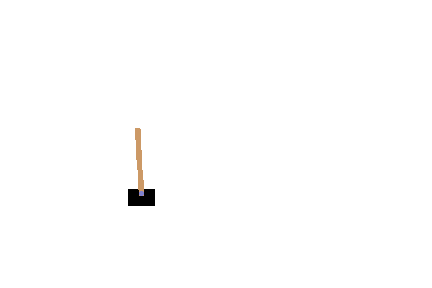
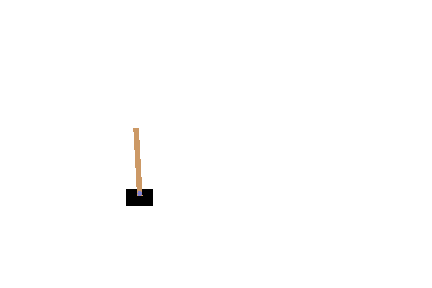
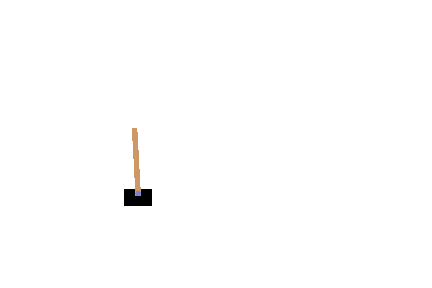
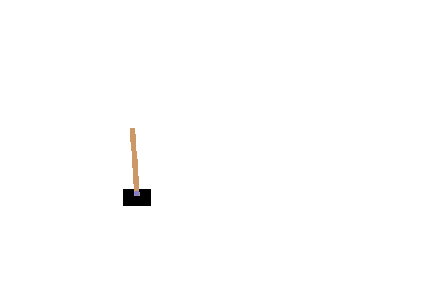
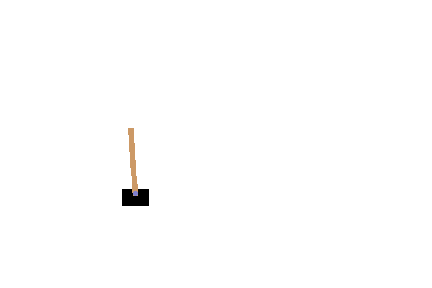
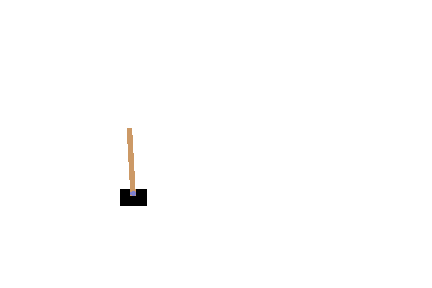
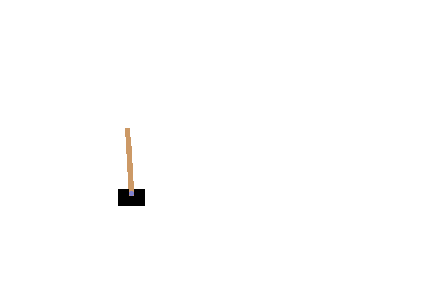
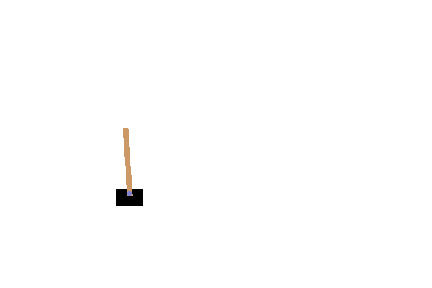
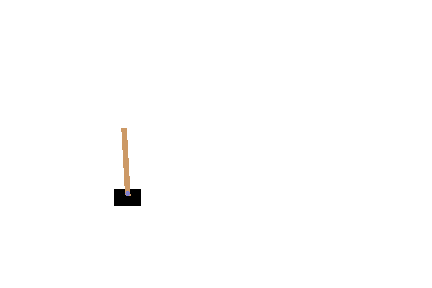
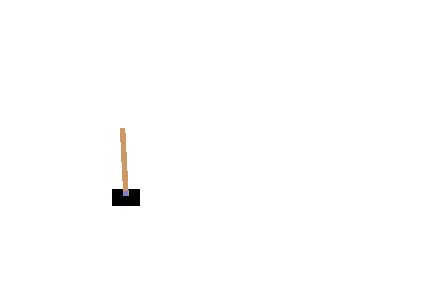
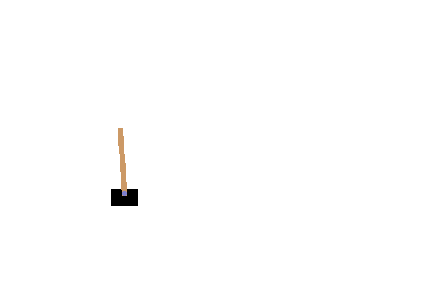
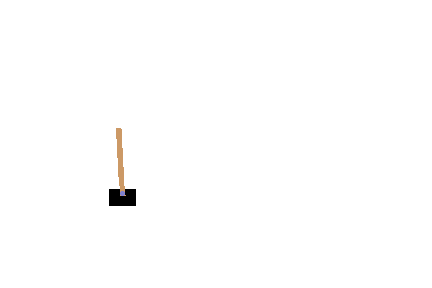
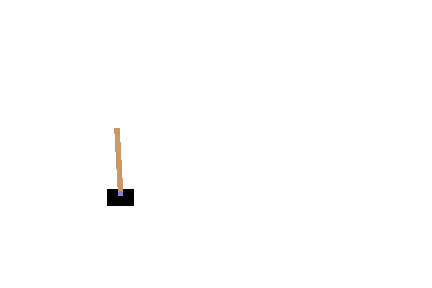
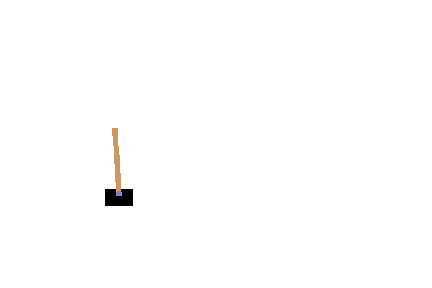
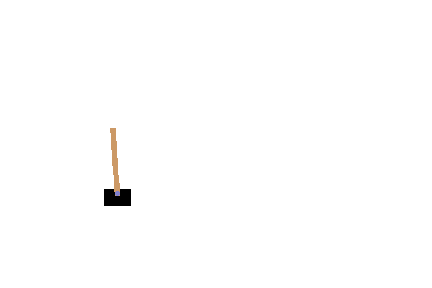
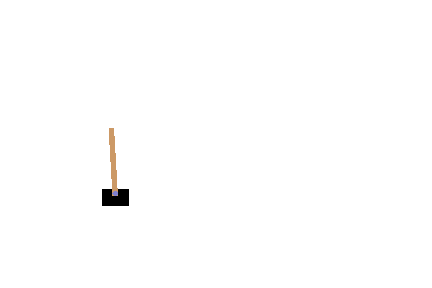
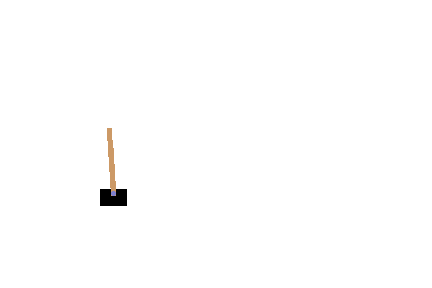
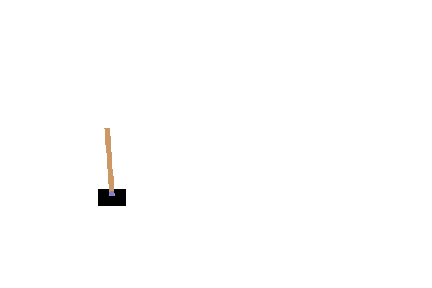
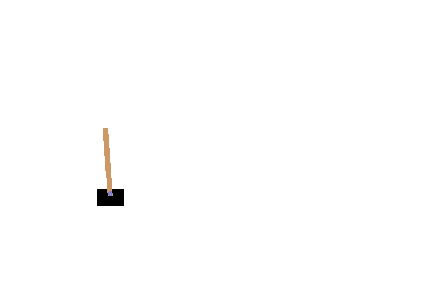
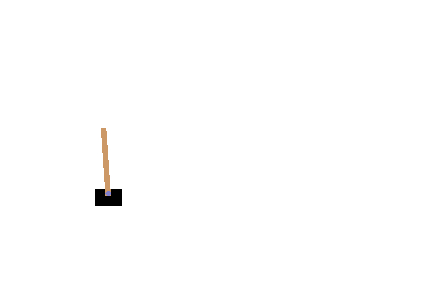
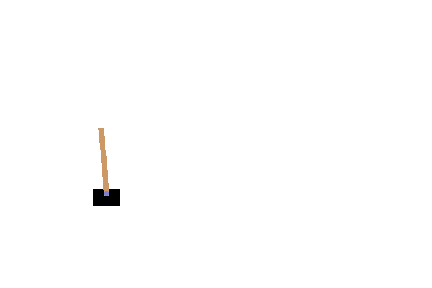
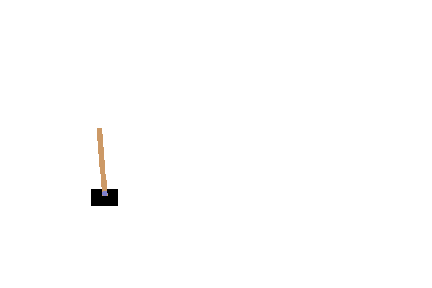
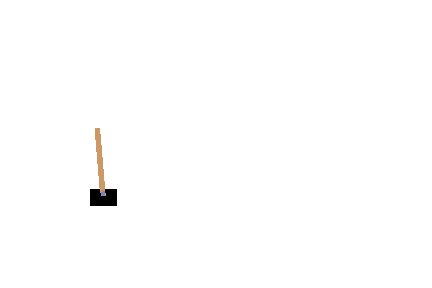
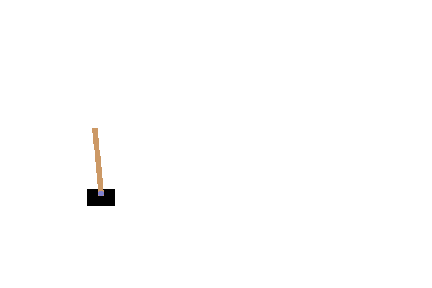
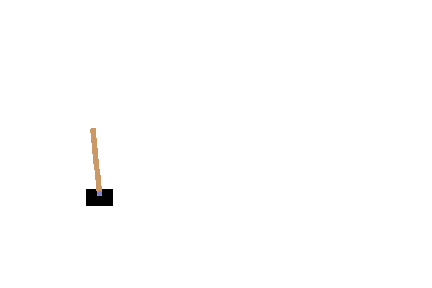
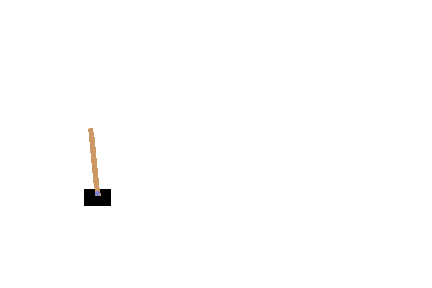
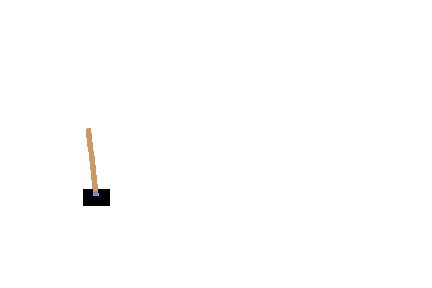
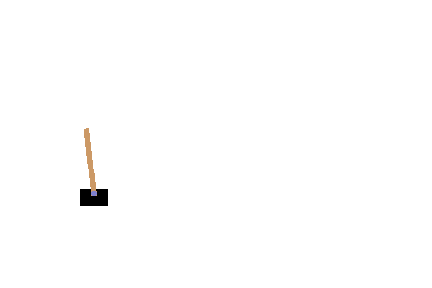
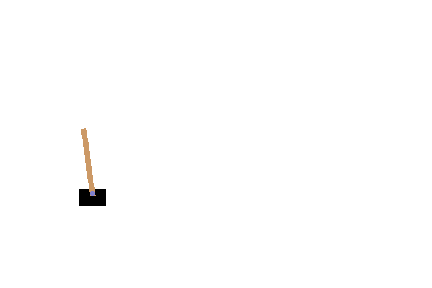
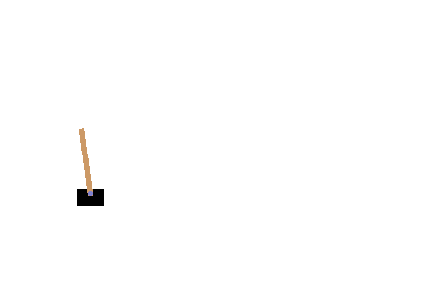
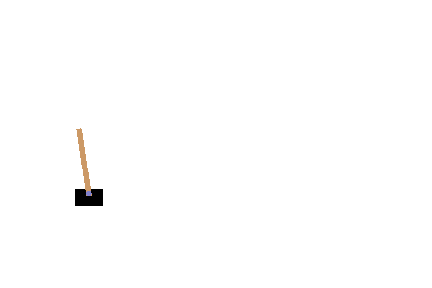
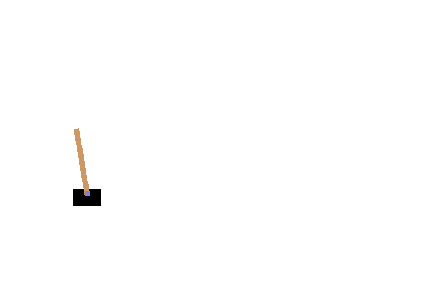
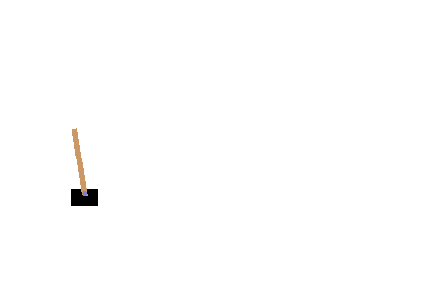
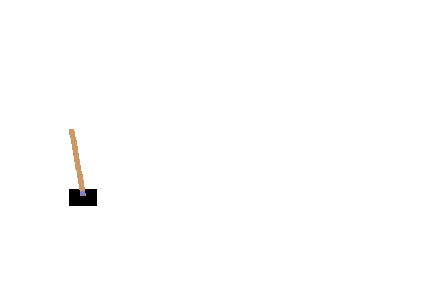
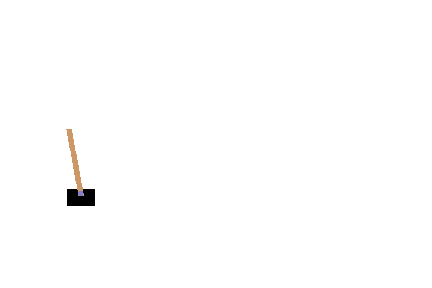
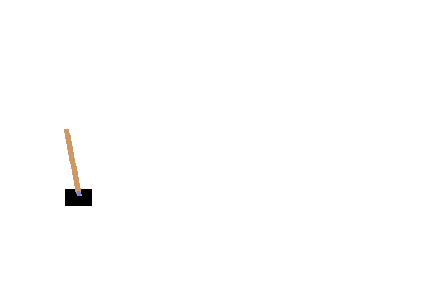
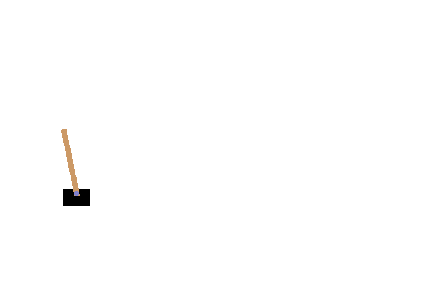
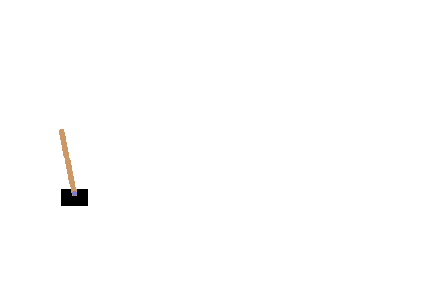
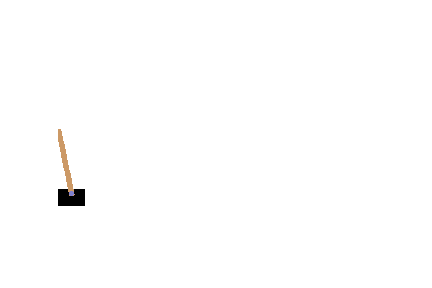
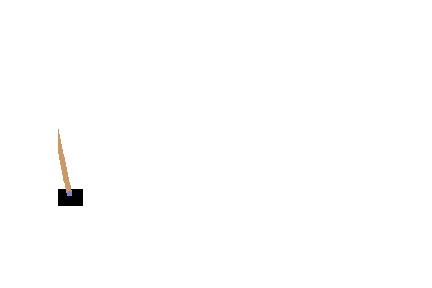

In [3]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

## util function to render CartPole as GIF image
def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

# evaluate trained agent
state = env.reset()
frames = []
t = 0
while True:
    frames.append(env.render(mode='rgb_array'))
    action = agent.act(state)
    state, _, done, _ = env.step(action)
    t += 1
    if done or t > 200:
        break
env.render(close=True)
display_frames_as_gif(frames)

## DQN on Atari
Training DQN for Atari games seriously takes a long time. So in this lecture, you just check behaviour of a trained model on Pong.

[2017-08-26 23:11:04,486] Making new env: PongDeterministic-v4



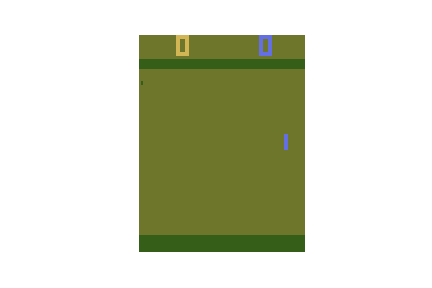
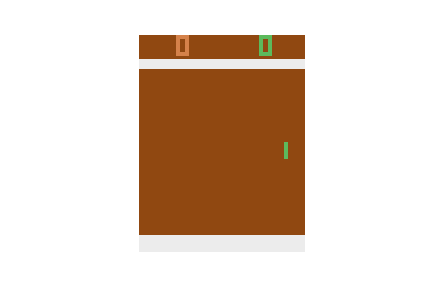
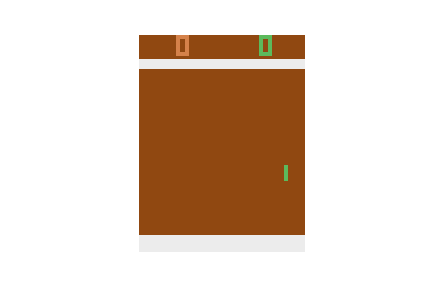
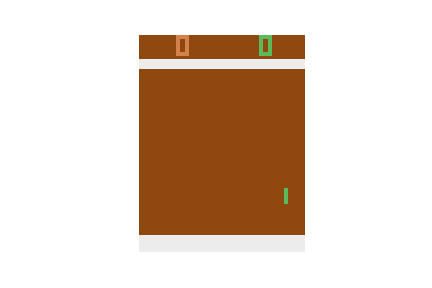
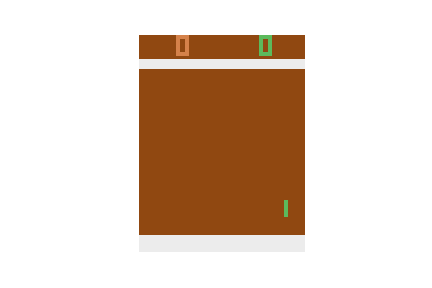
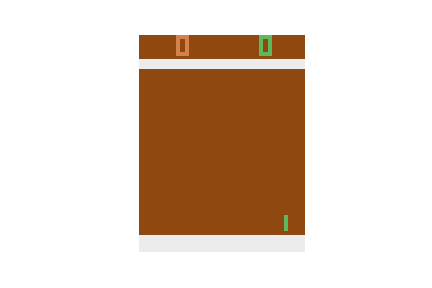
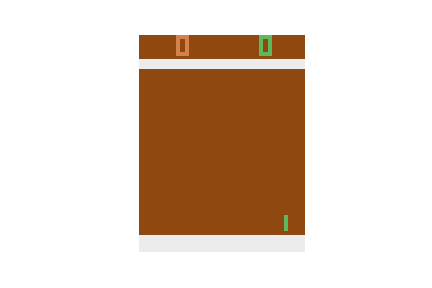
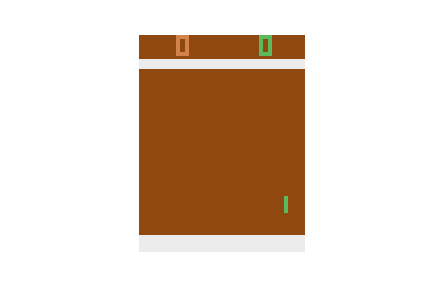
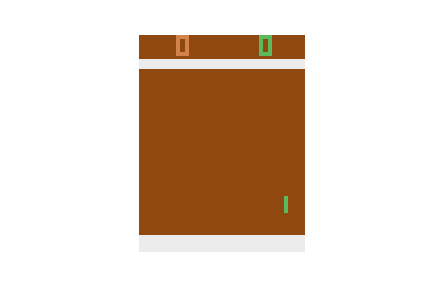
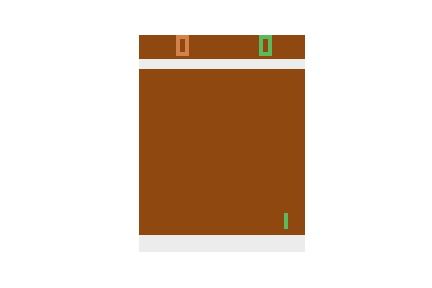
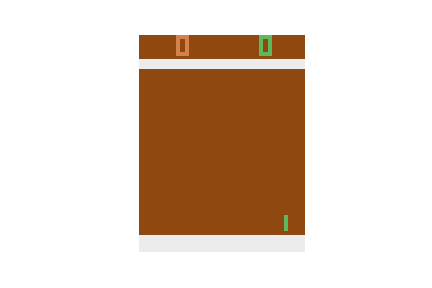
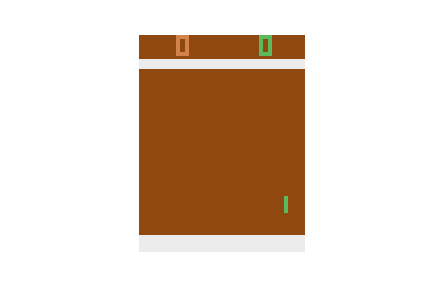
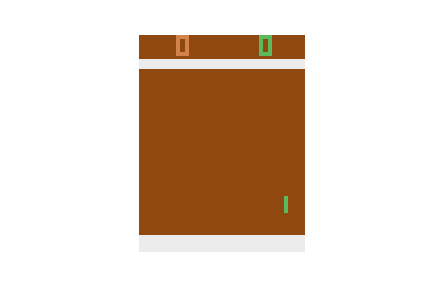
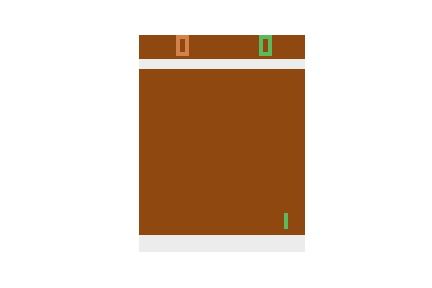
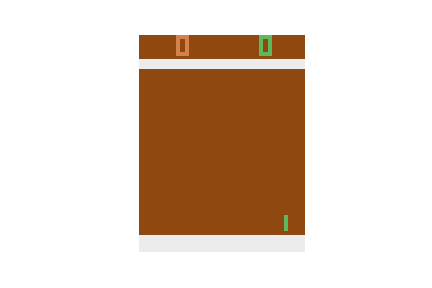
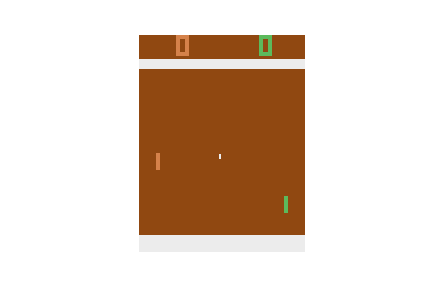
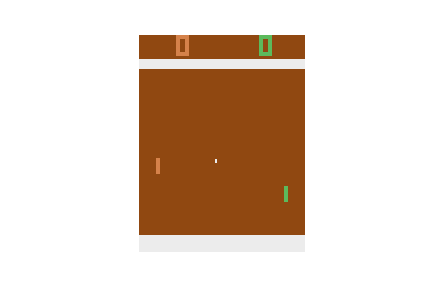
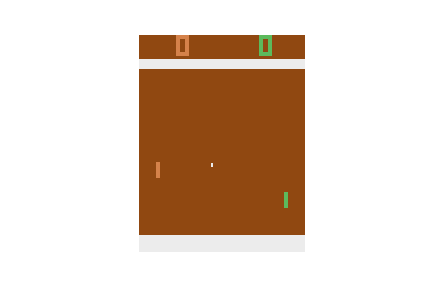
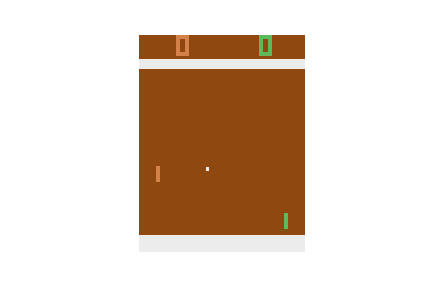
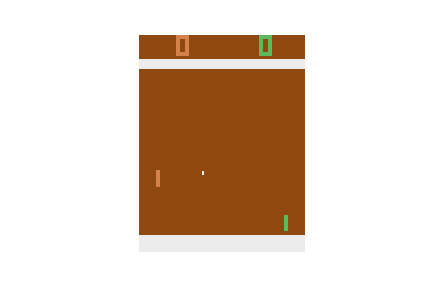
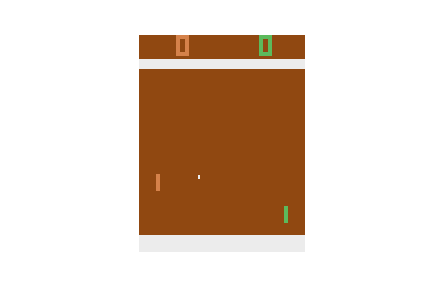
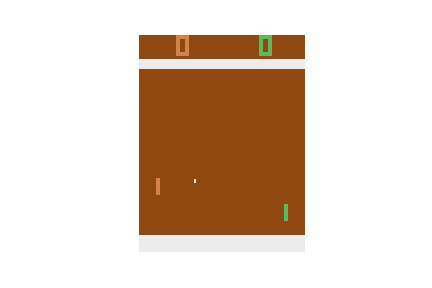
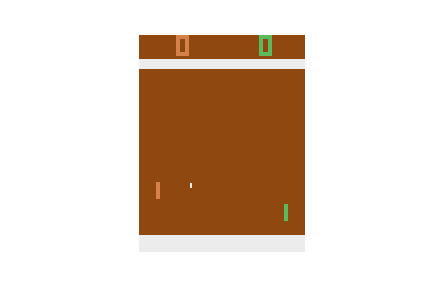
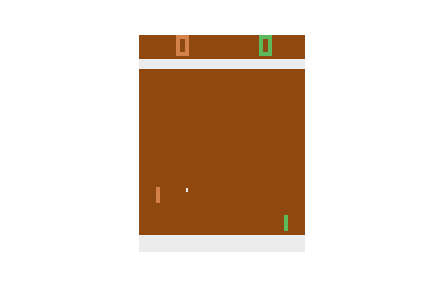
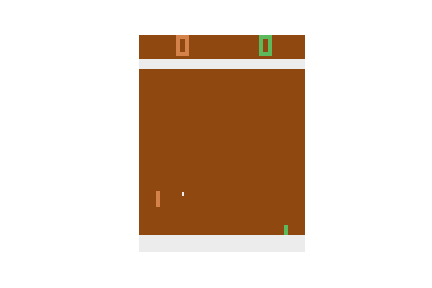
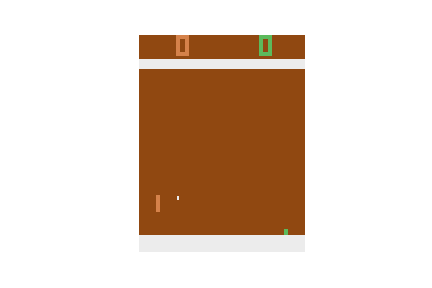
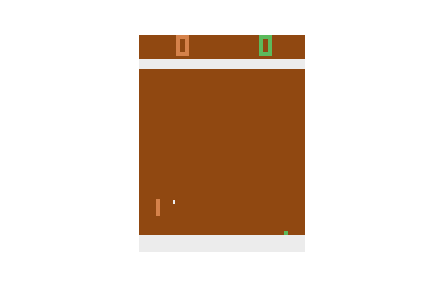
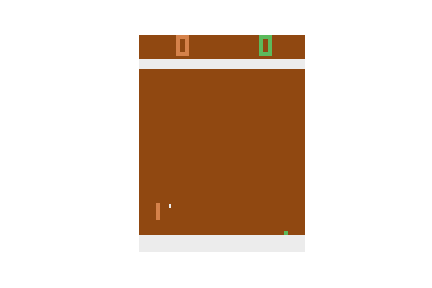
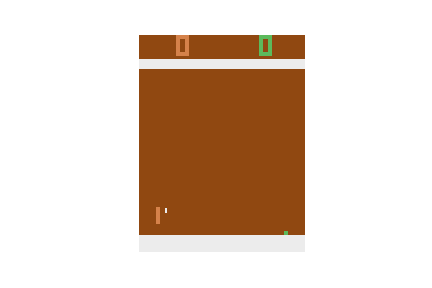
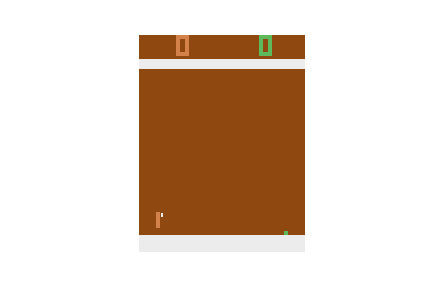
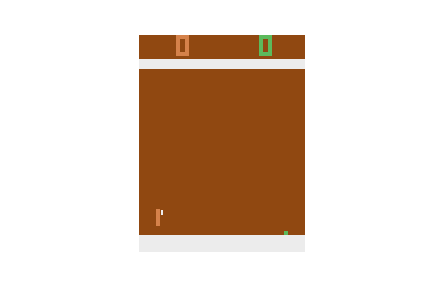
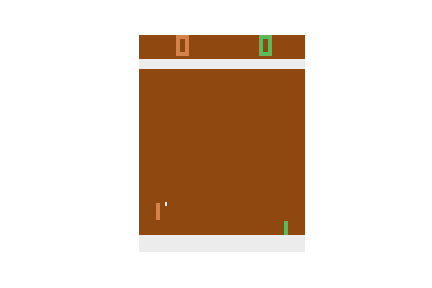
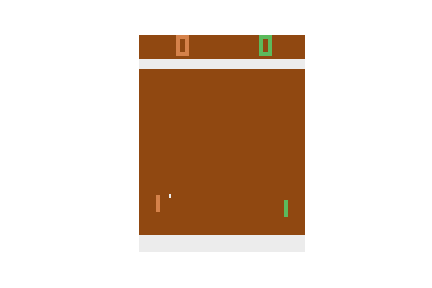
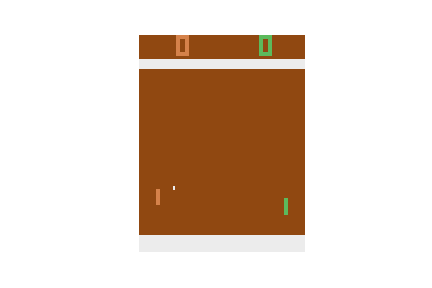
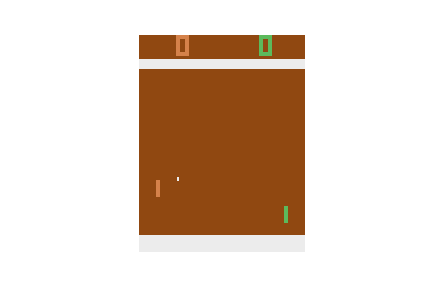
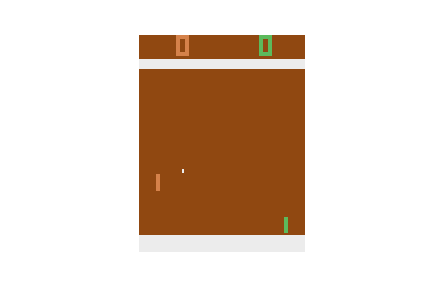
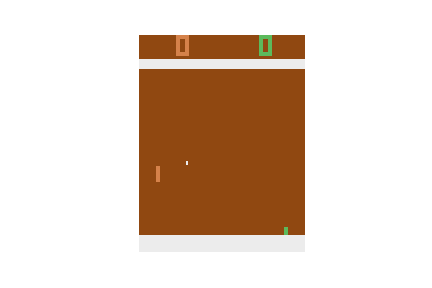
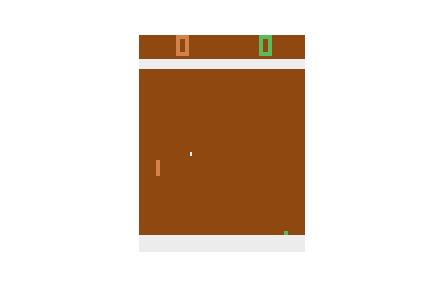
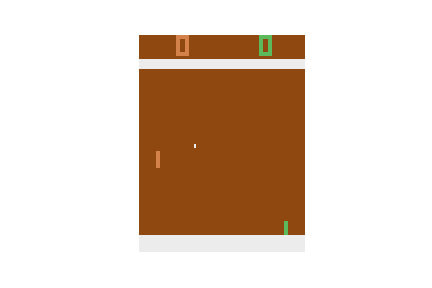
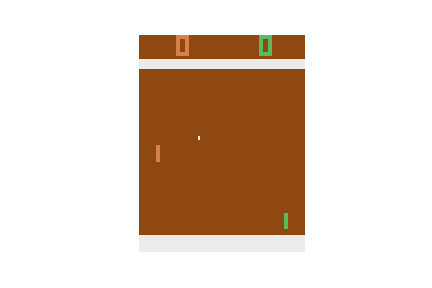
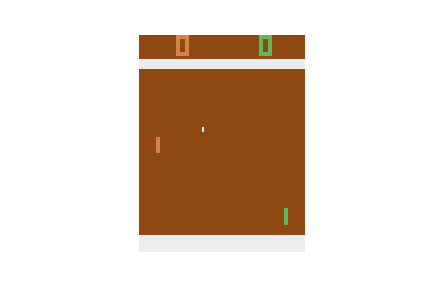
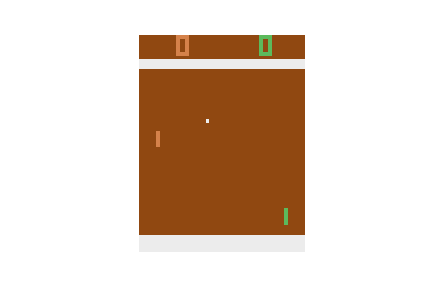
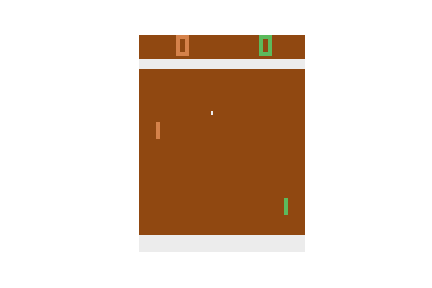
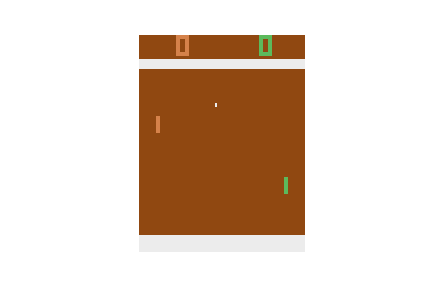
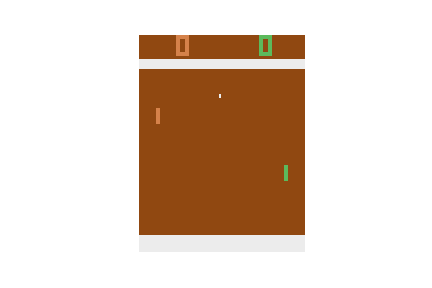
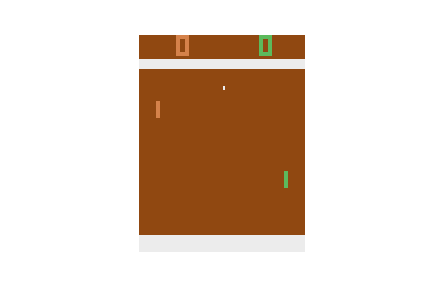
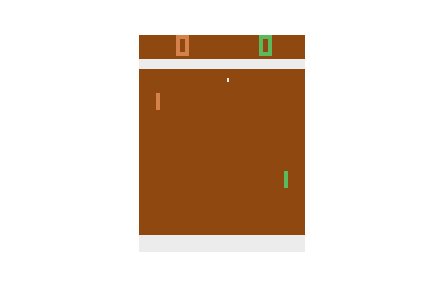
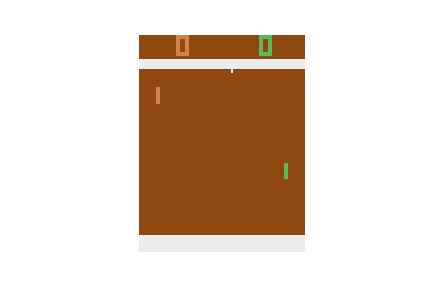
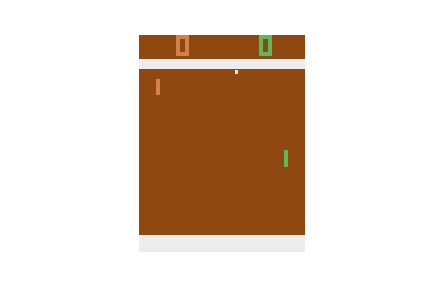
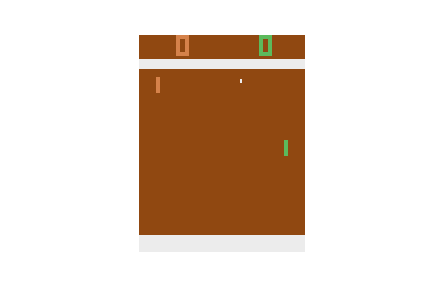
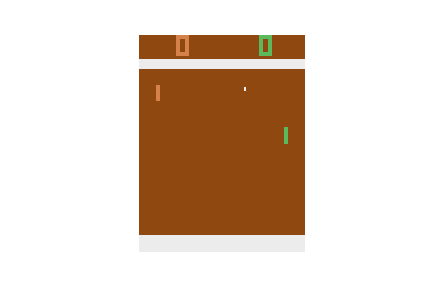
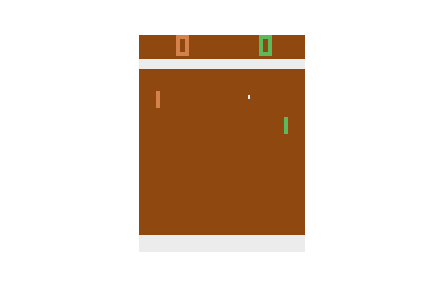
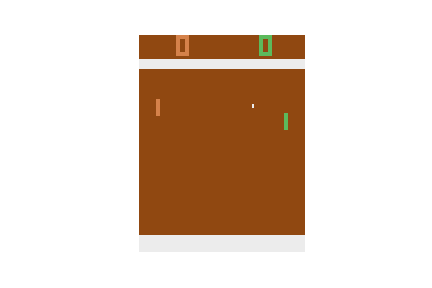
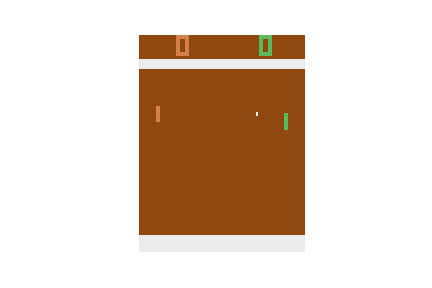
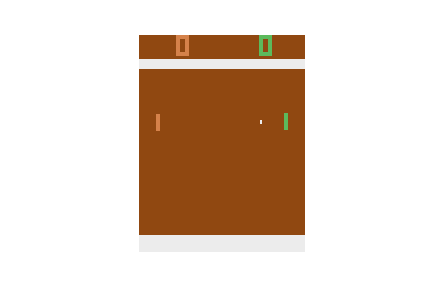
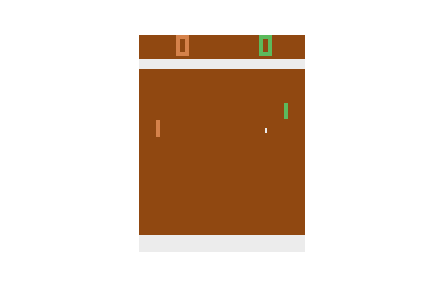
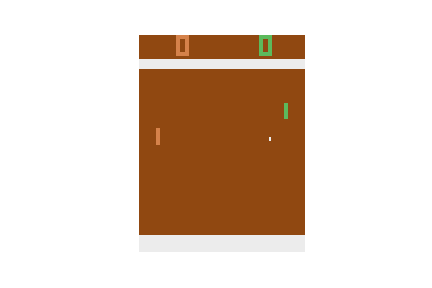
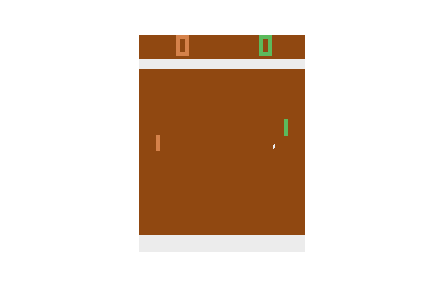
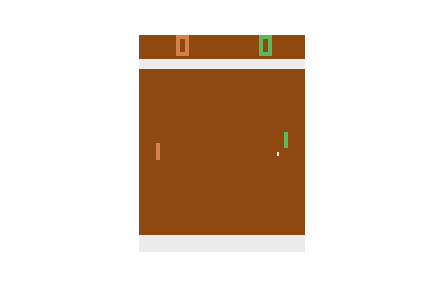
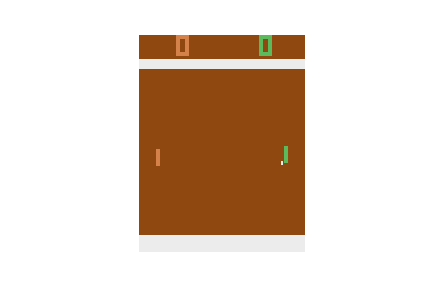
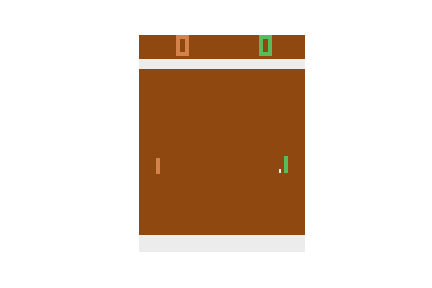
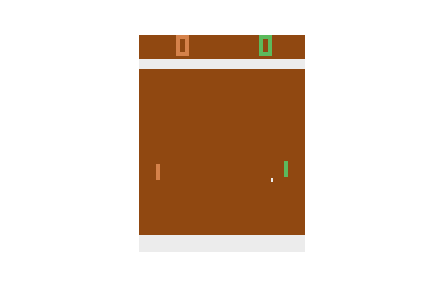
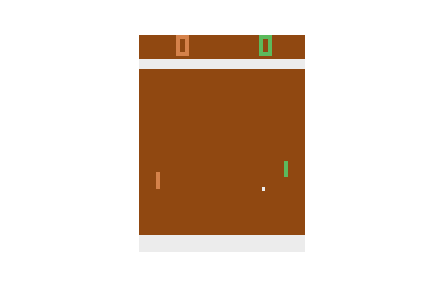
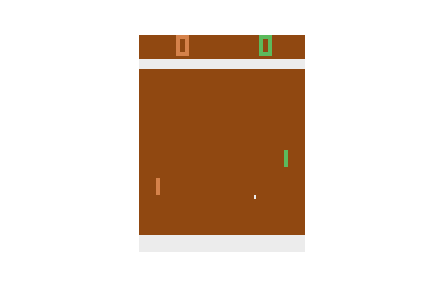
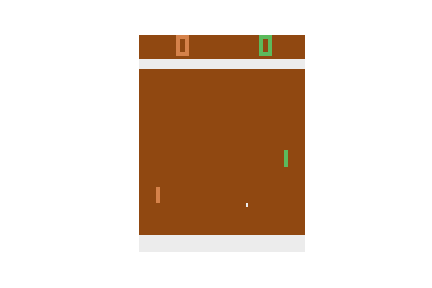
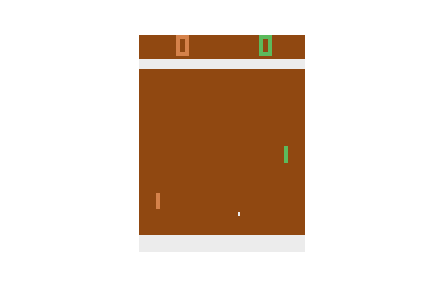
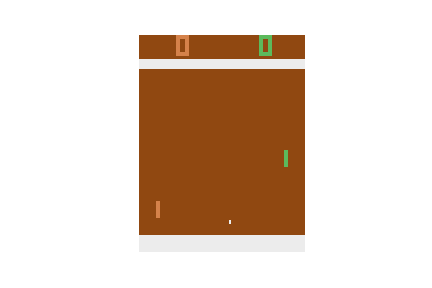
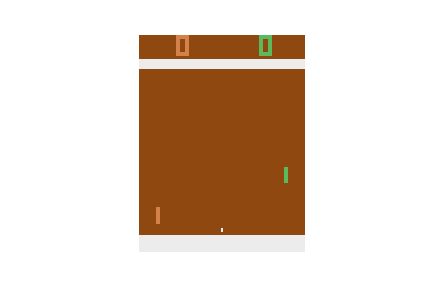
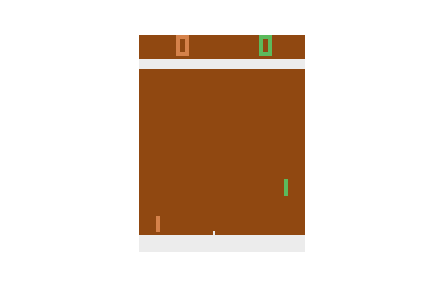
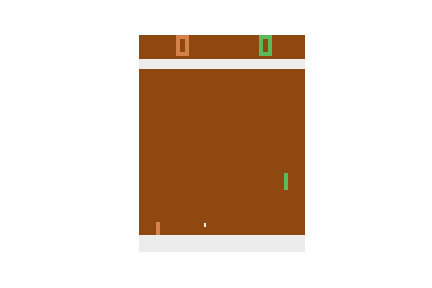
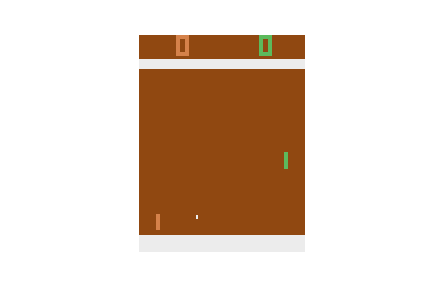
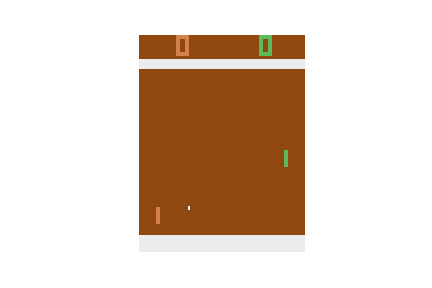
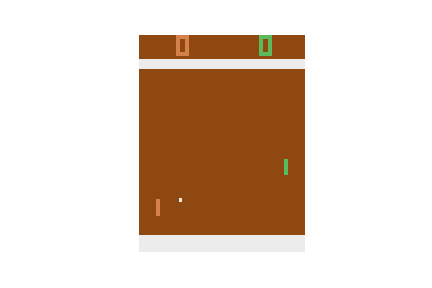
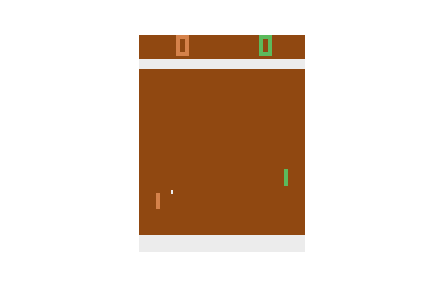
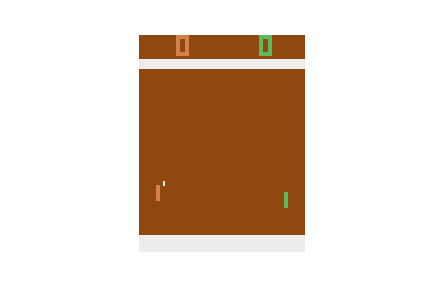
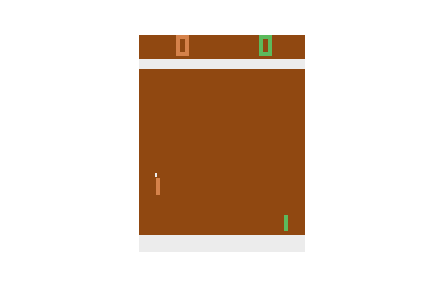
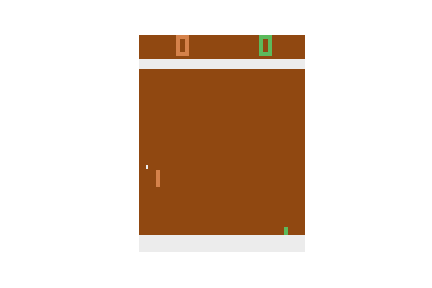
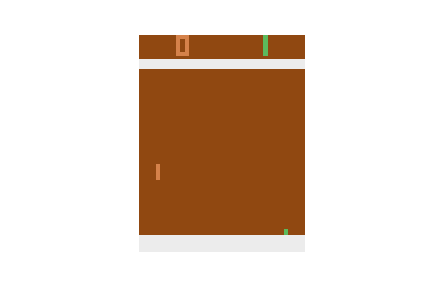
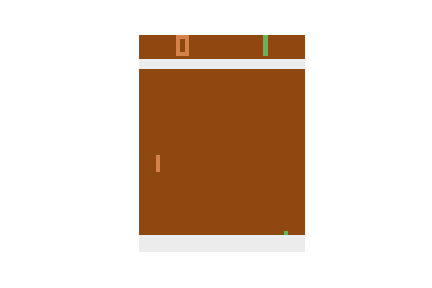
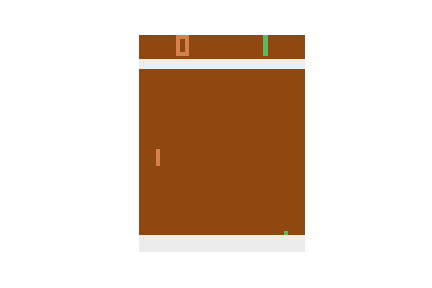
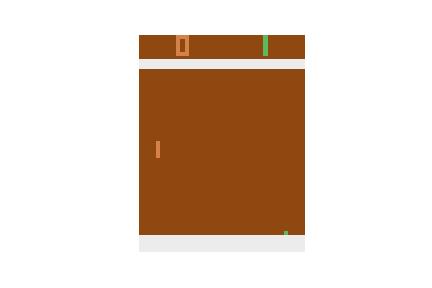
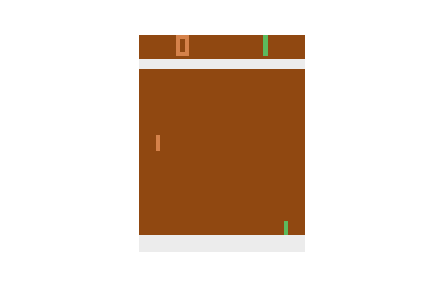
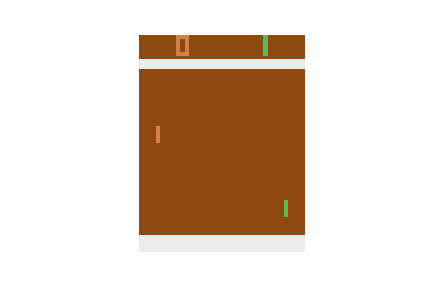
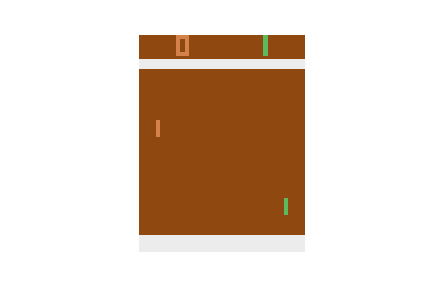
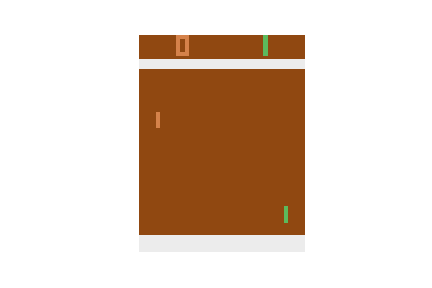
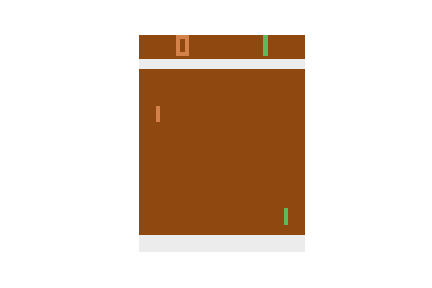
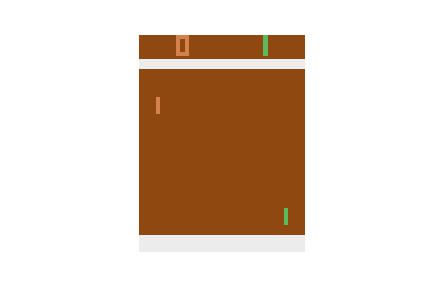
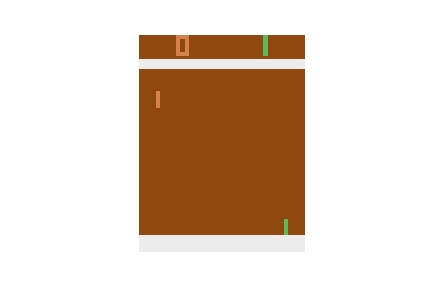
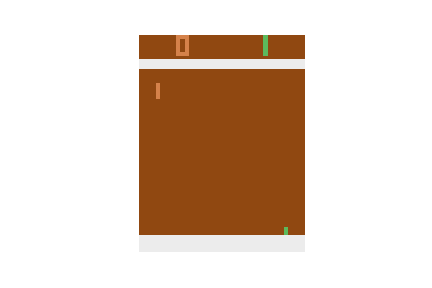
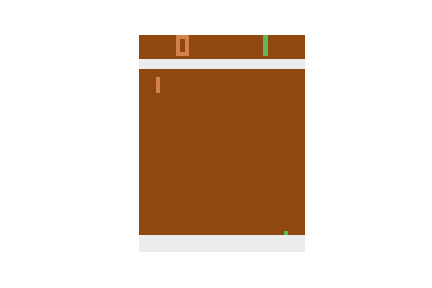
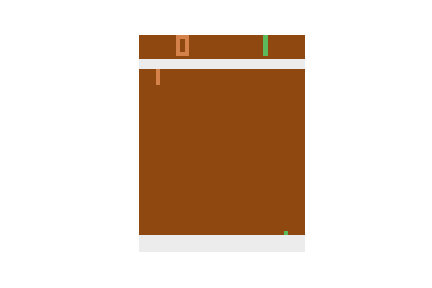
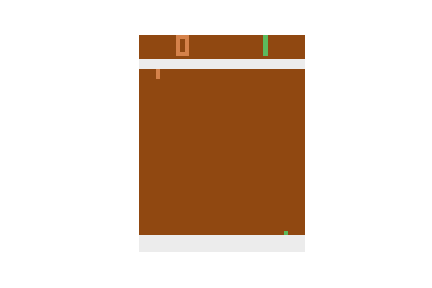
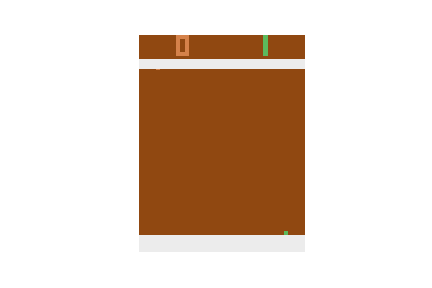
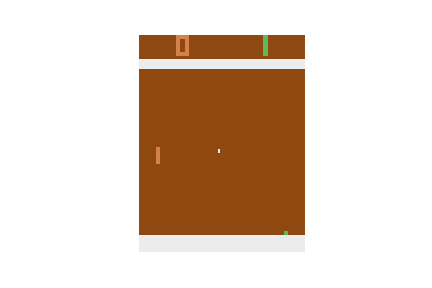
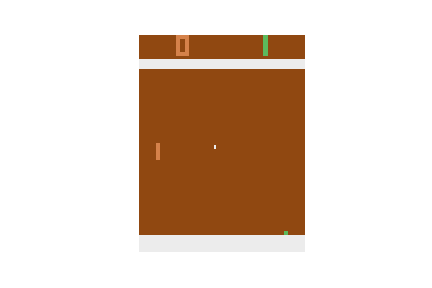
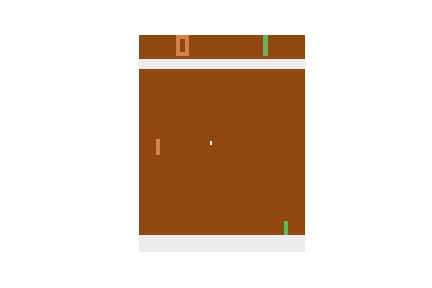
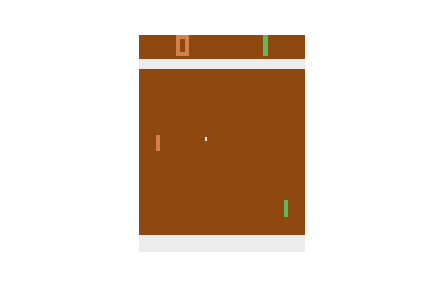
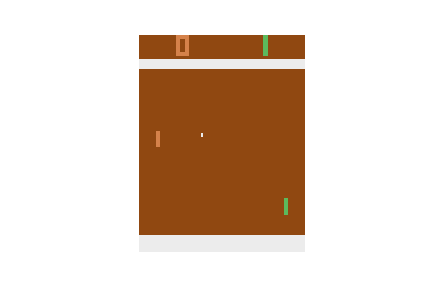
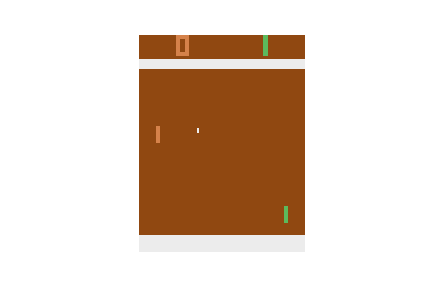
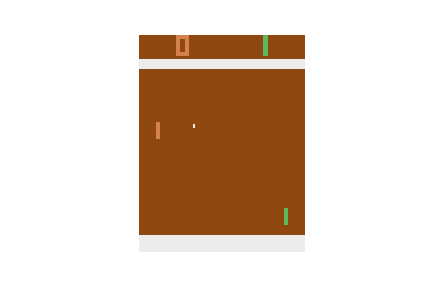
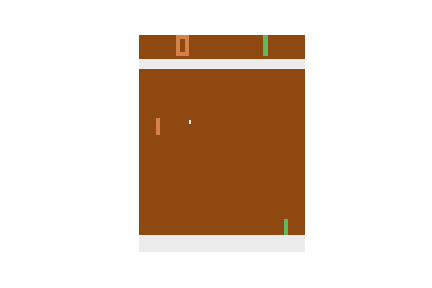
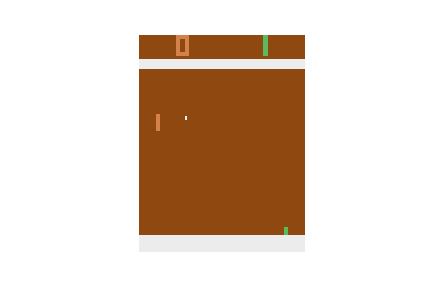
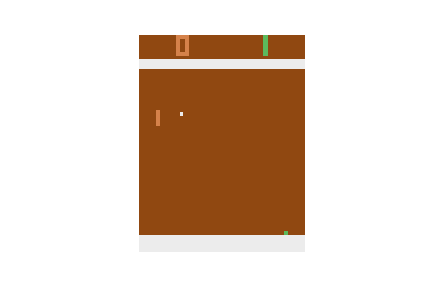
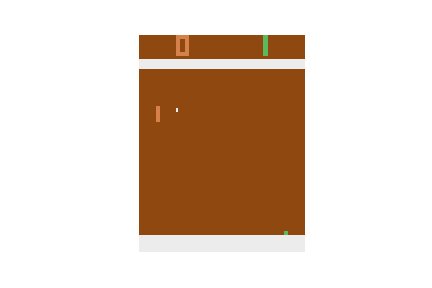
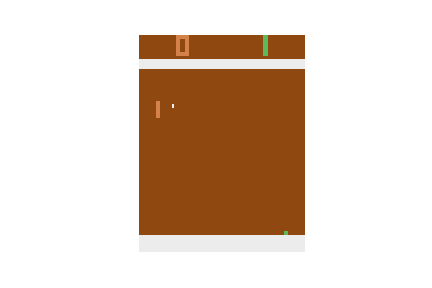
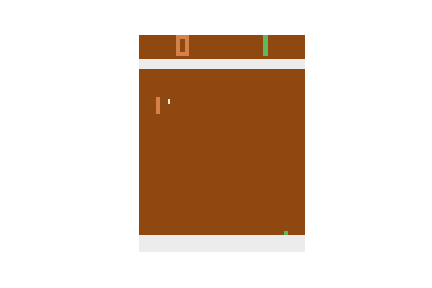
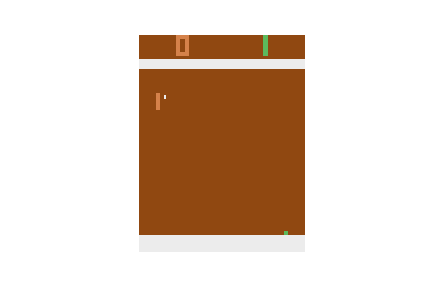
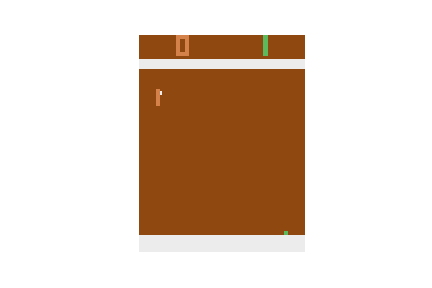
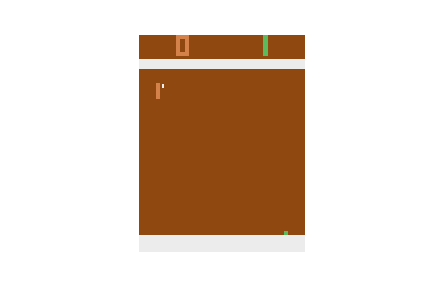
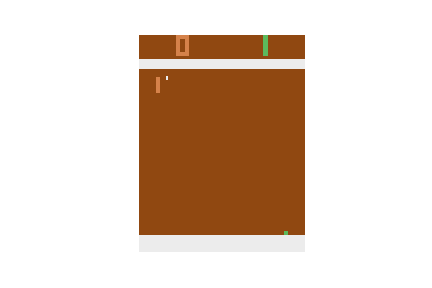
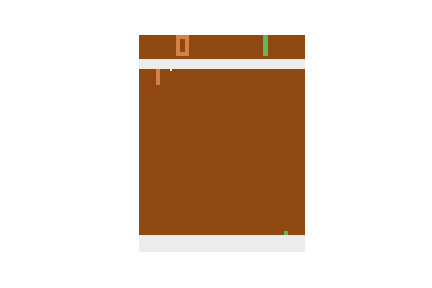
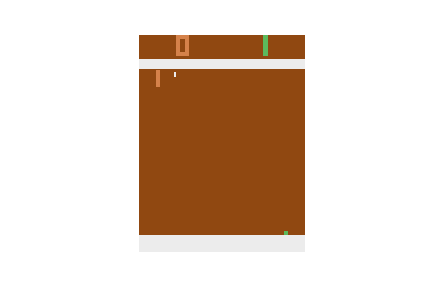
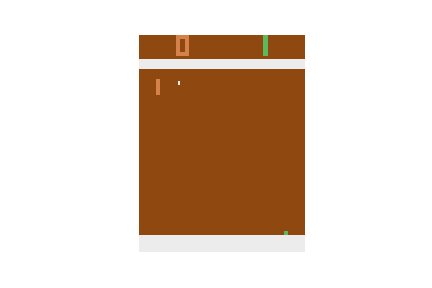
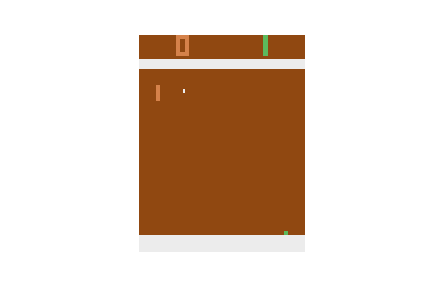
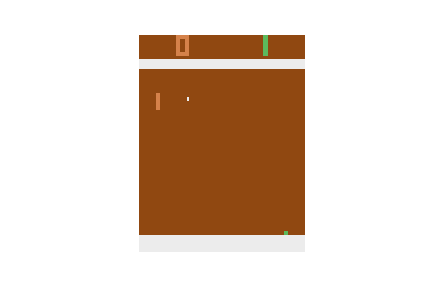
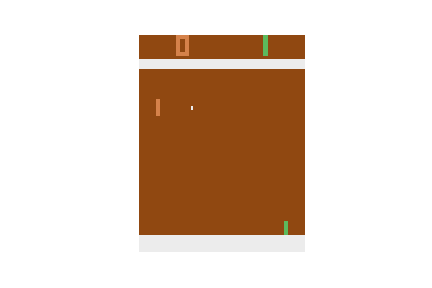
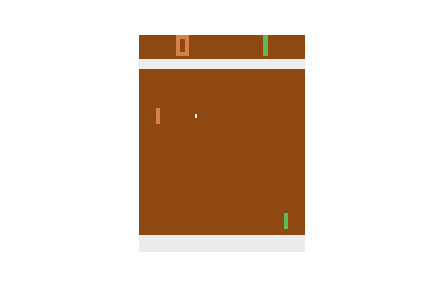
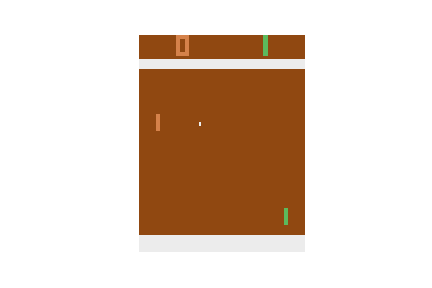
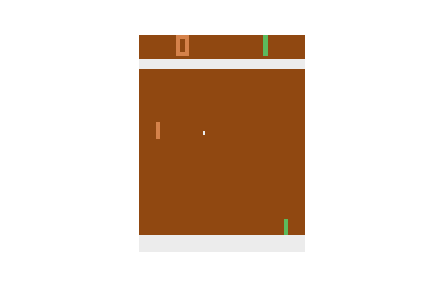
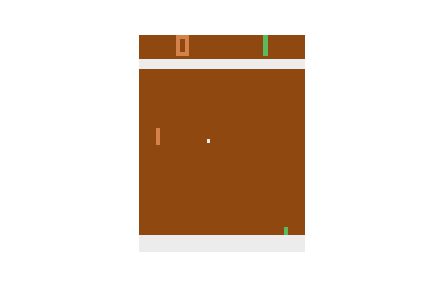
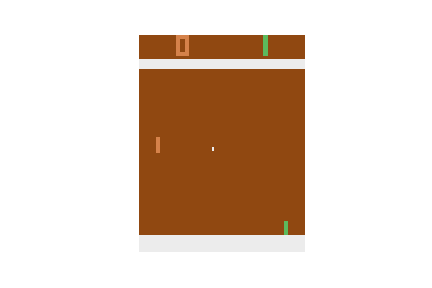
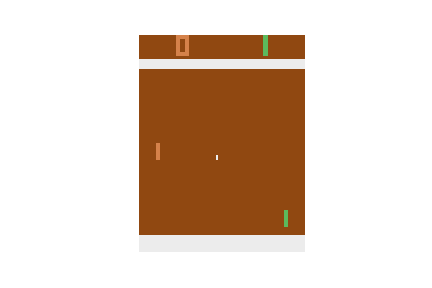
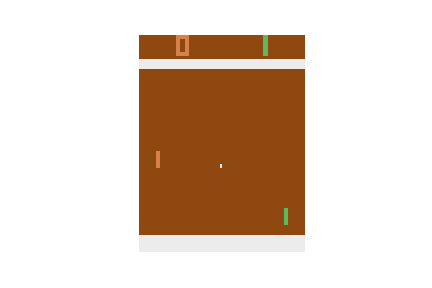
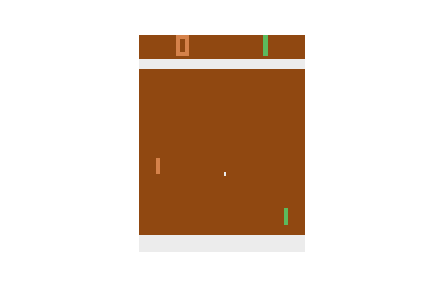
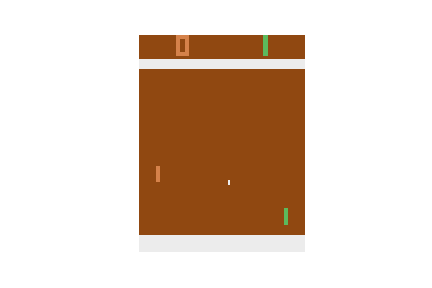
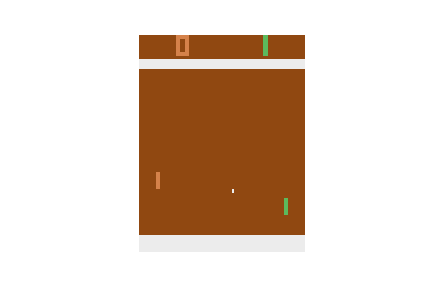
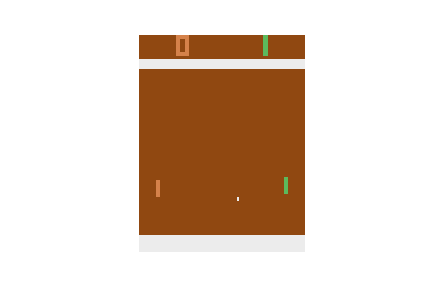
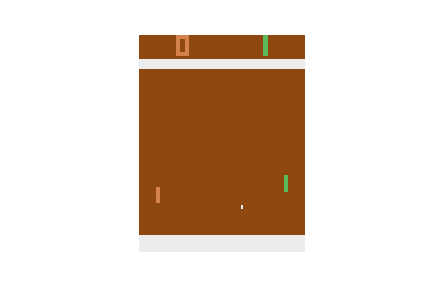
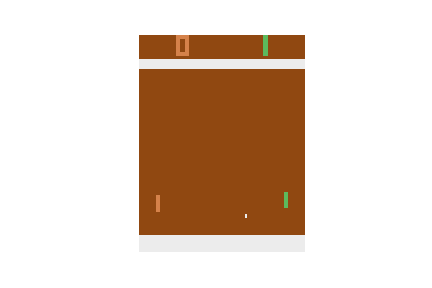
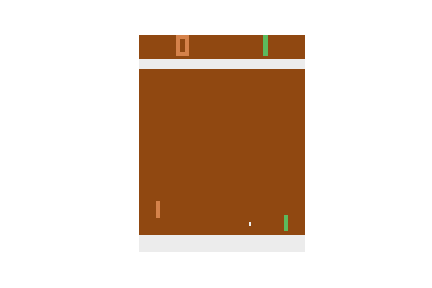
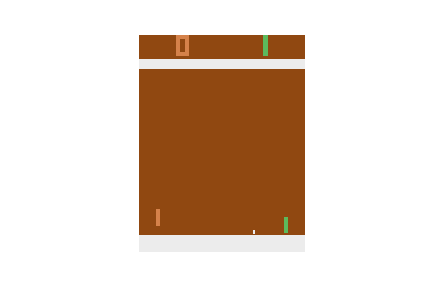
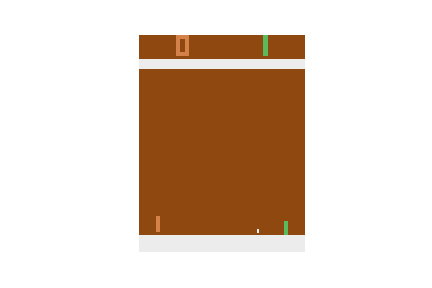
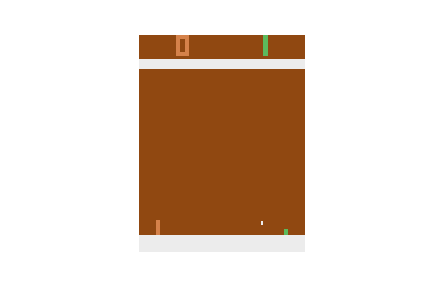
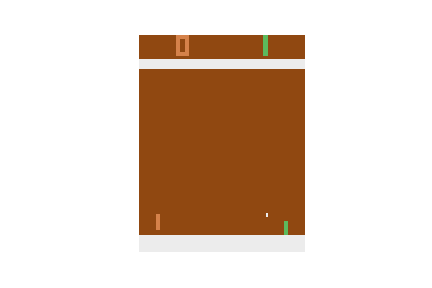
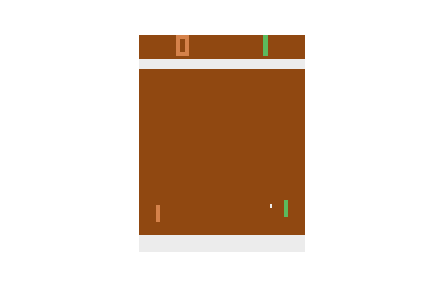
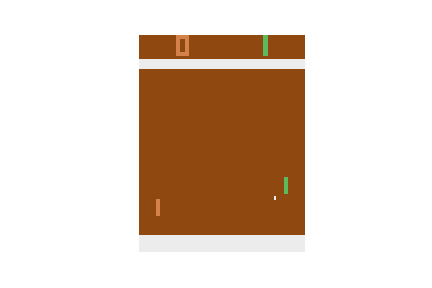
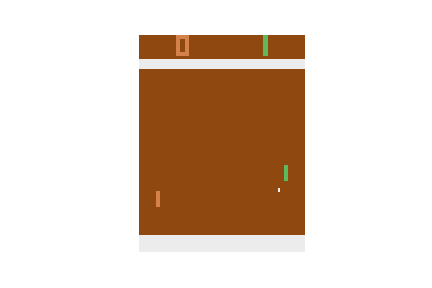
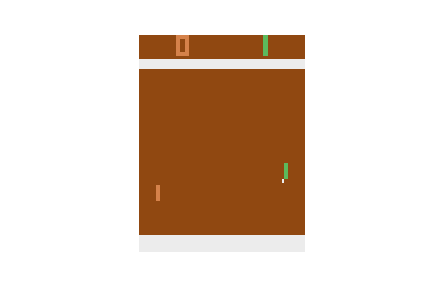
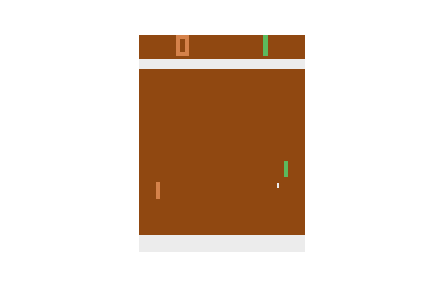
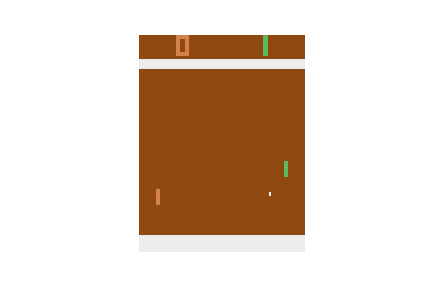
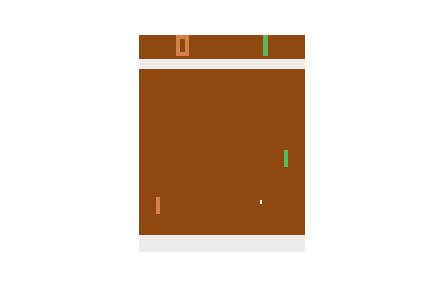
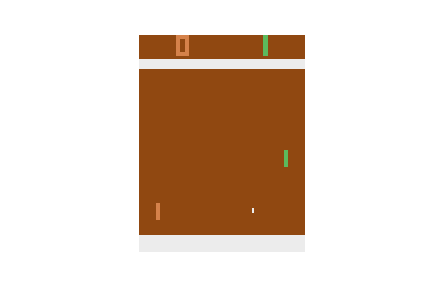
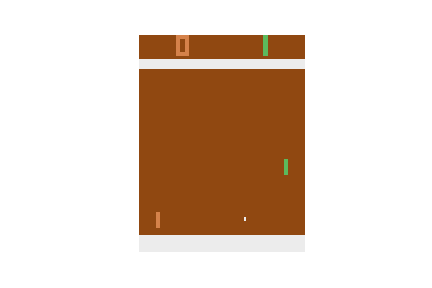
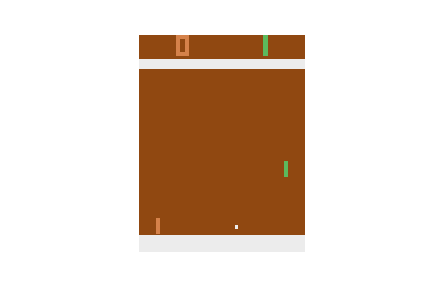
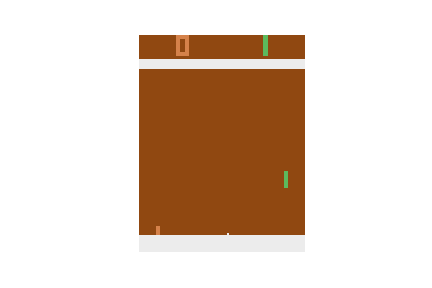
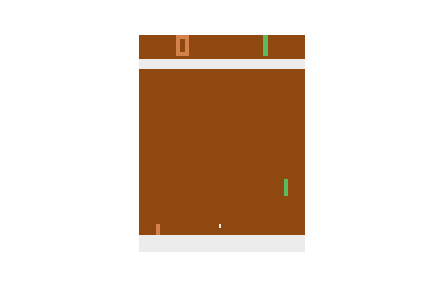
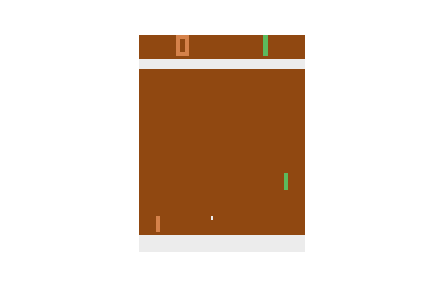
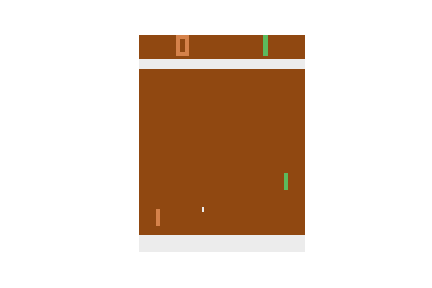
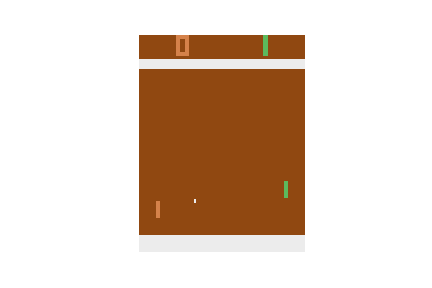
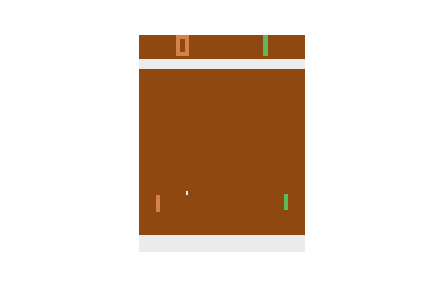
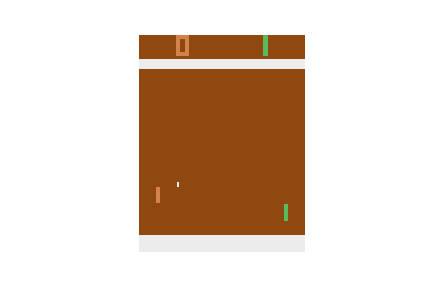
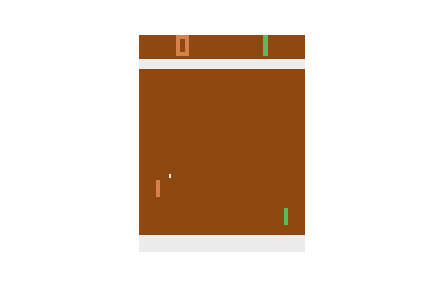
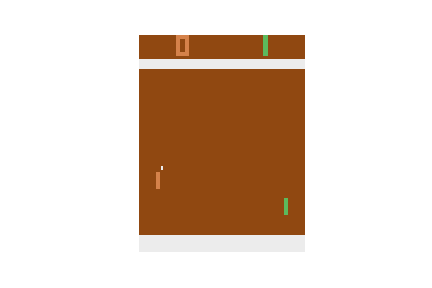
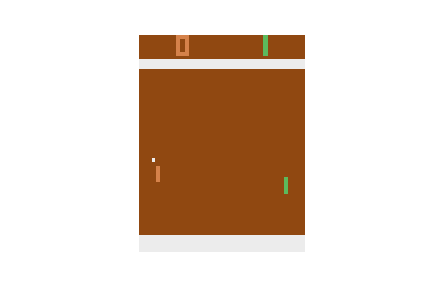
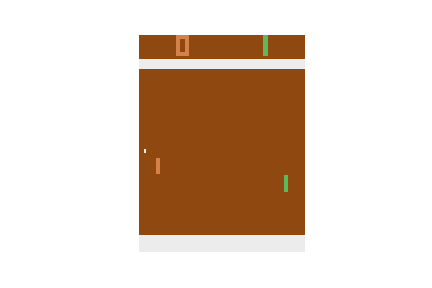
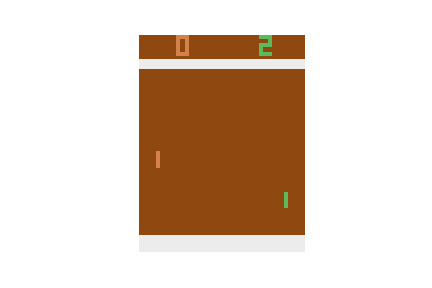
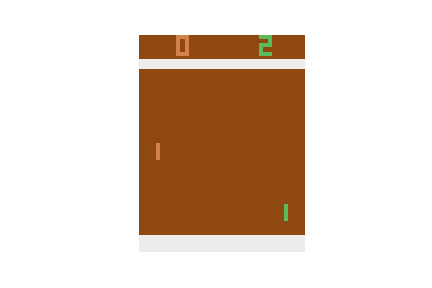
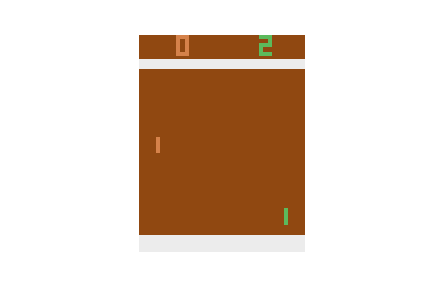
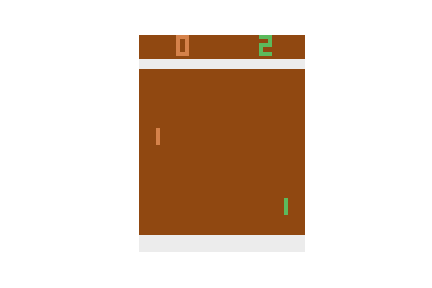
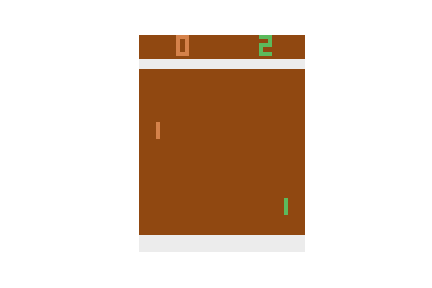
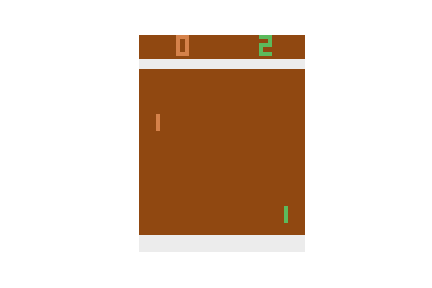
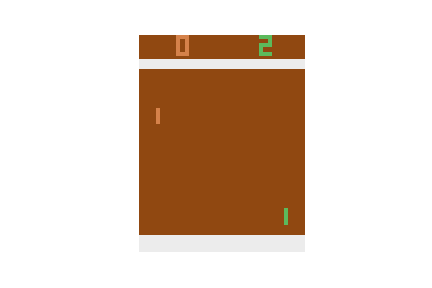
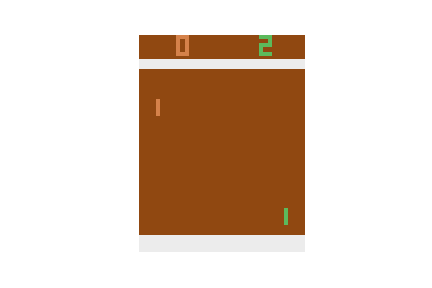
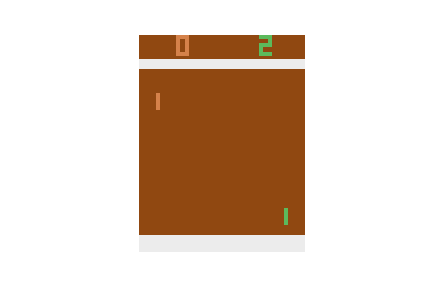
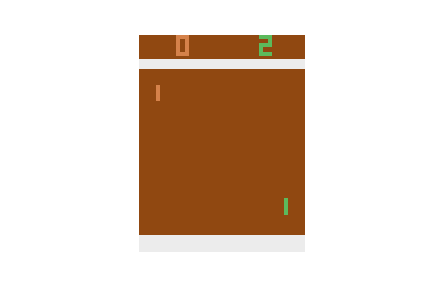
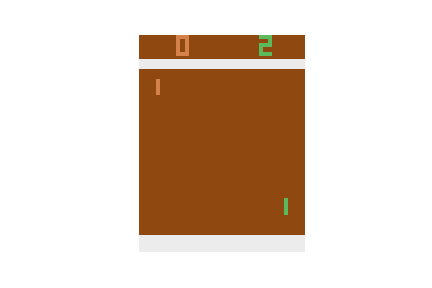
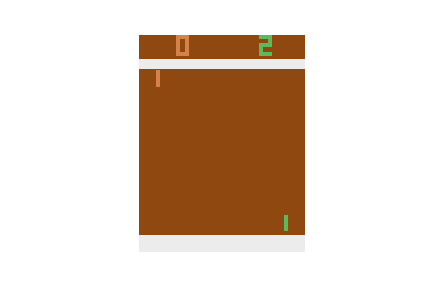
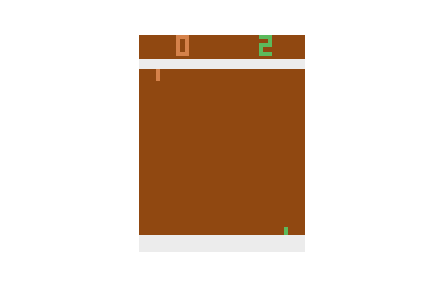
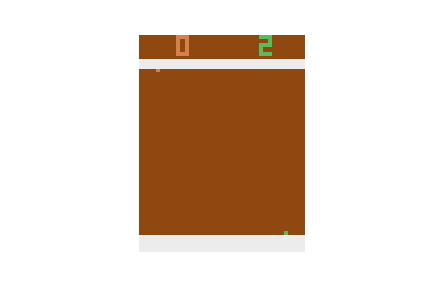
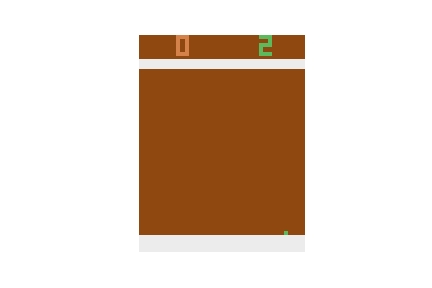
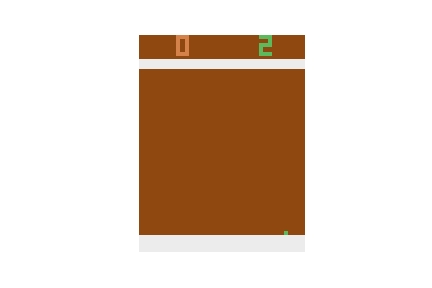
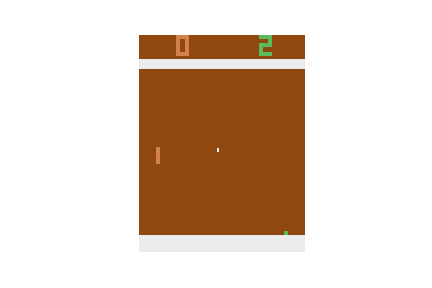
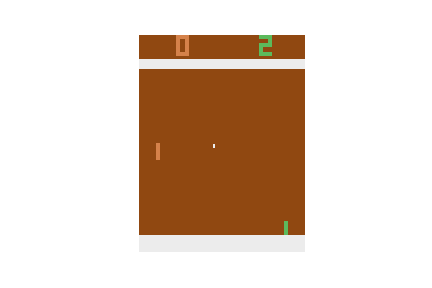
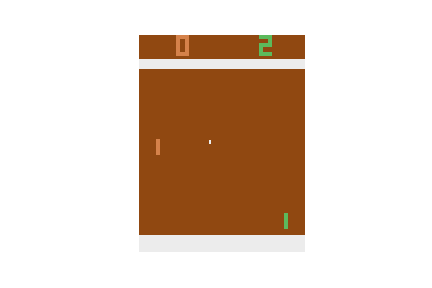
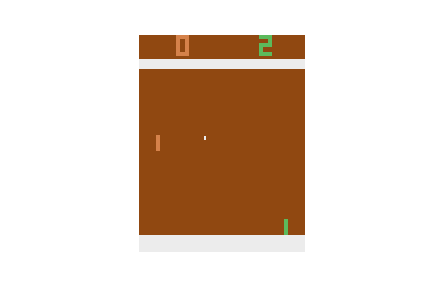
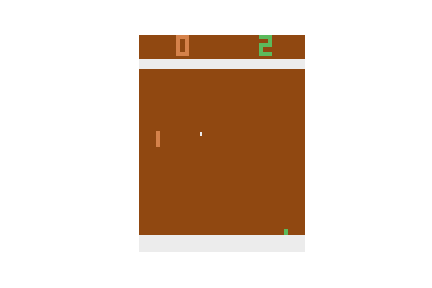
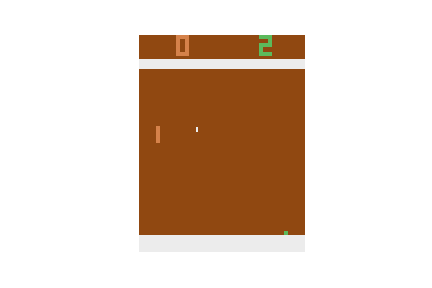
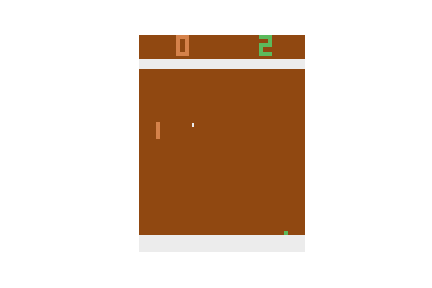
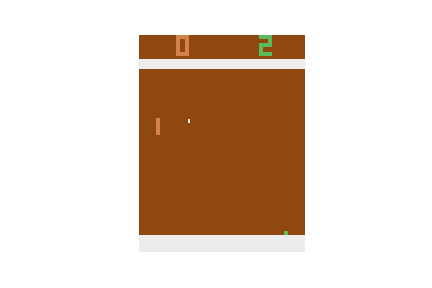
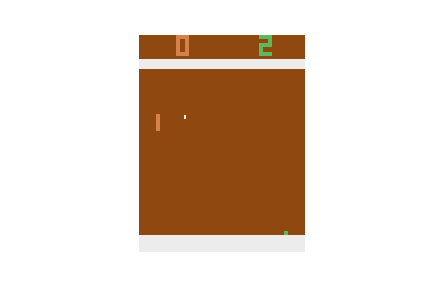
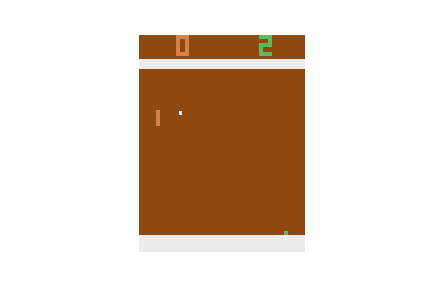
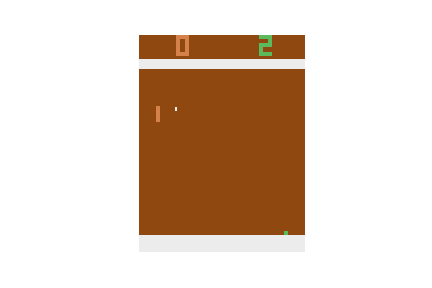
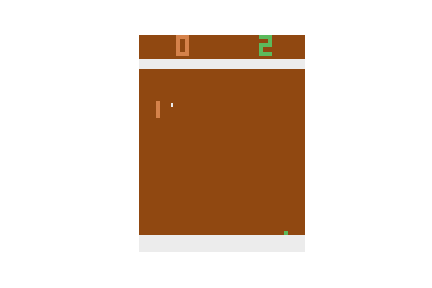
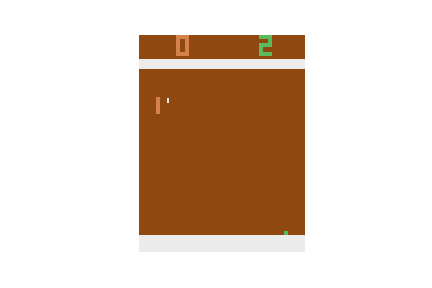
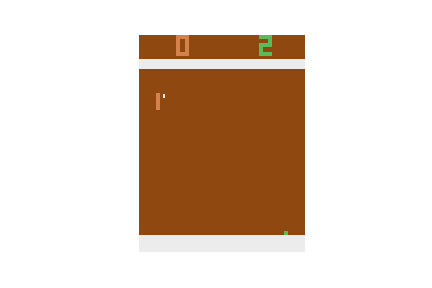
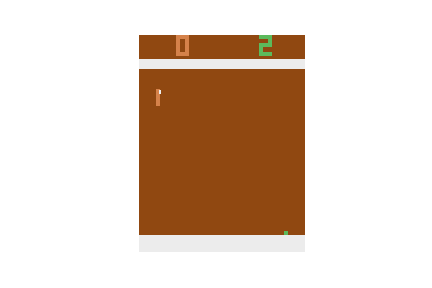
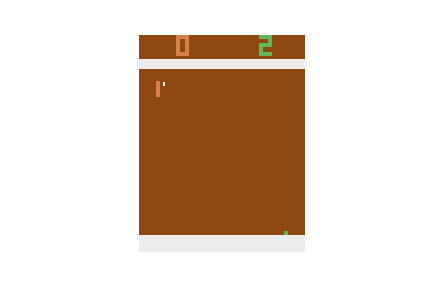
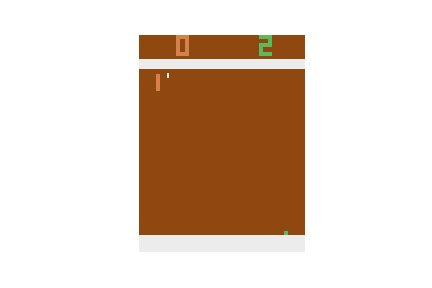
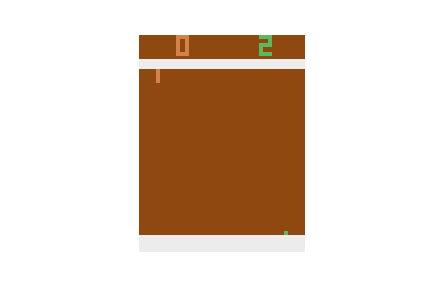
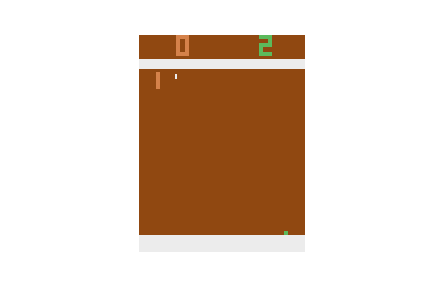
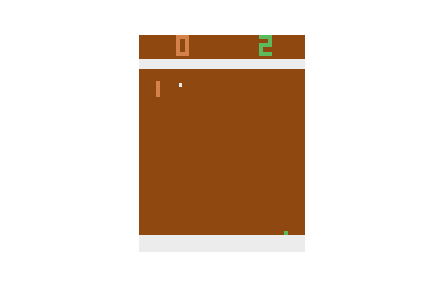
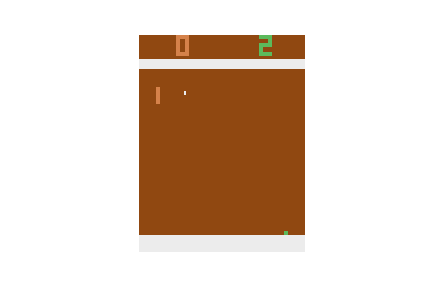
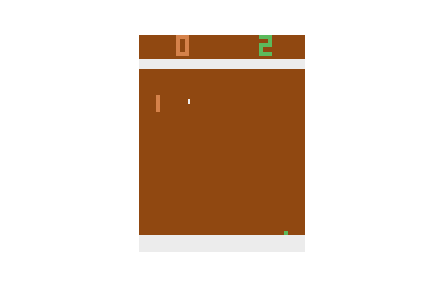
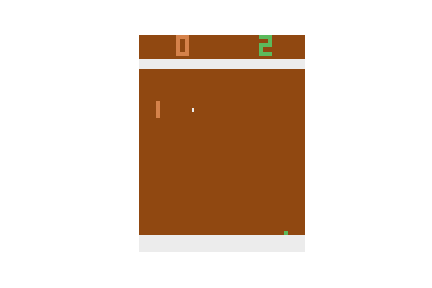
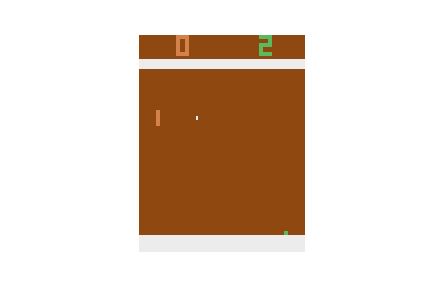
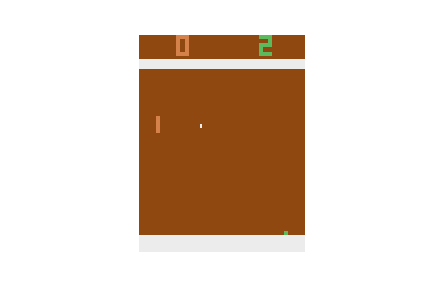
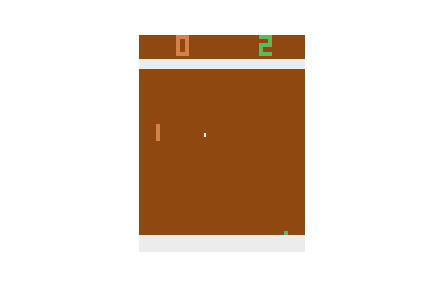
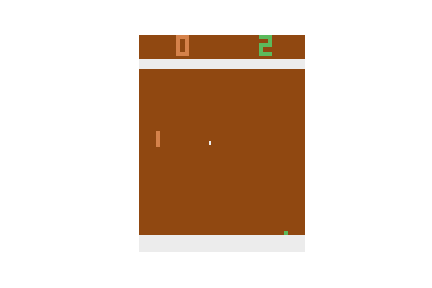
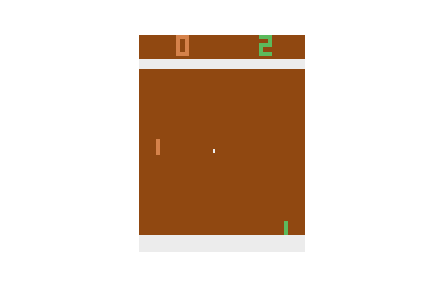
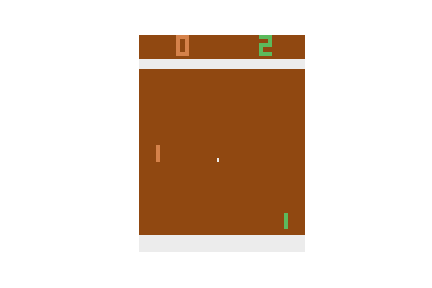
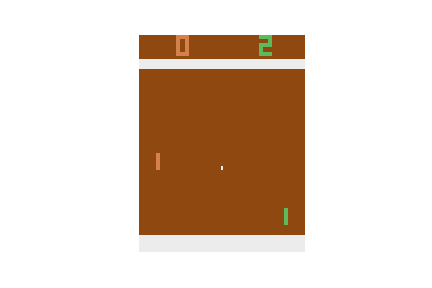

In [4]:
import os
import cv2
from chainerrl import links


env = gym.make('PongDeterministic-v4')

# ChainerRL provides some predefined networks
# in this case, q_func has 3 convolutional layers and 2 fully connected layers
# n_input_channels represents the number of images to feed networks
convs = links.NatureDQNHead(n_input_channels=4)
q_func = links.Sequence(convs, L.Linear(512, 6),
        chainerrl.action_value.DiscreteActionValue)

# create optimizer to avoid errors when loading trained models
# but this RMSprop optimizer is actually same as the one in the paper
optimizer = chainer.optimizers.RMSpropGraves(
        lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)
optimizer.setup(q_func)

# most of arguments are None because agent would not train here
agent = chainerrl.agents.DQN(
    q_func, optimizer, None, None, None,
    phi=lambda x: np.array(x, dtype=np.float32) / 255.0)

# load a trained model
agent.load(os.path.join(os.getcwd(), 'trained'))

# deque object to hold 4 frames for frame skipping
states = deque(np.zeros((4, 84, 84)).tolist(), maxlen=4)

# evaluate trained agent
state = env.reset()
frames = []
t = 0
while True:
    # process input images
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    state = cv2.resize(state, (84, 84))
    states.append(state)
    
    frames.append(env.render(mode='rgb_array'))
    action = agent.act(list(reversed(states)))
    state, _, done, _ = env.step(action)
    t += 1
    if done or t > 200:
        break
env.render(close=True)
display_frames_as_gif(frames)

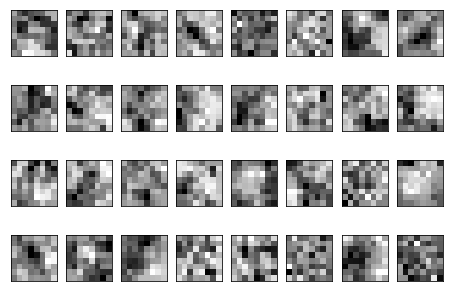

In [5]:
def visualize_conv_layer(weight, shape=(8, 8)):
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    for i in range(weight.shape[0]):
        ax = fig.add_subplot(shape[0], shape[1], i + 1, xticks=[], yticks=[])
        ax.imshow(weight[i][0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

# visualize the first convolutional layer
visualize_conv_layer(convs[0].W.data, (4, 8))

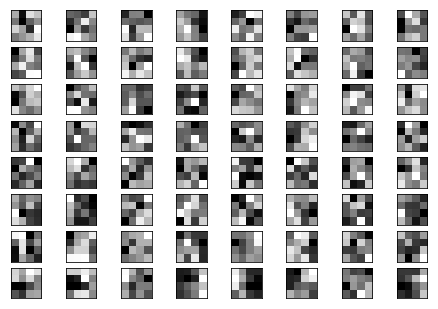

In [6]:
# visualize the second convolutional layer
visualize_conv_layer(convs[1].W.data)

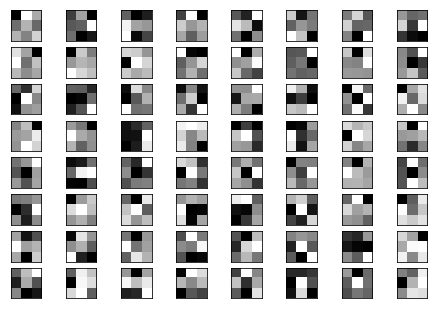

In [7]:
# visualize the third convolutional layer
visualize_conv_layer(convs[2].W.data)

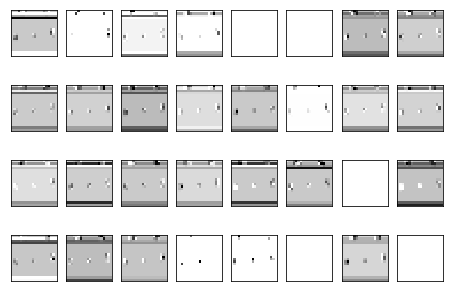

In [8]:
def visualize_activations(activations, shape=(8, 8)):
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    for i in range(activations.shape[0]):
        ax = fig.add_subplot(shape[0], shape[1], i + 1, xticks=[], yticks=[])
        ax.imshow(activations[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

states = deque(np.zeros((4, 84, 84)).tolist(), maxlen=4)
env.reset()
for i in range(15):
    state, _, _, _ = env.step(0)
    state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
    state = cv2.resize(state, (84, 84))
    states.append(state)

# visualize activations on the first layer
h = F.relu(convs[0](np.array([list(reversed(states))], dtype=np.float32) / 255.0))
visualize_activations(h.data[0], (4, 8))

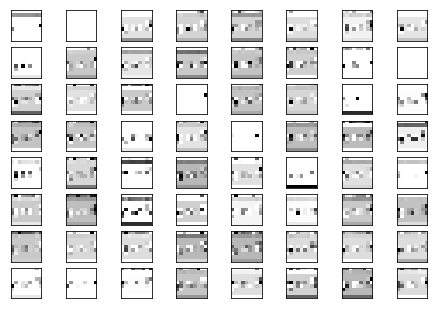

In [9]:
# visualize activations on the second layer
h = F.relu(convs[1](h))
visualize_activations(h.data[0])

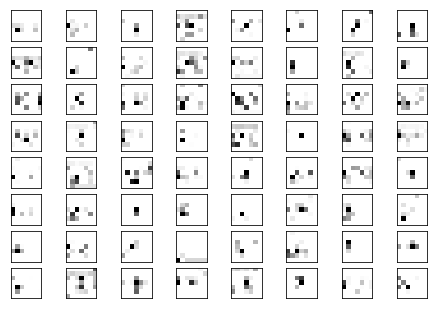

In [10]:
# visualize activations on the third layer
h = F.relu(convs[2](h))
visualize_activations(h.data[0])